In [15]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
import keras.backend as K
from keras.models import model_from_json
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats

import sys
sys.path.append('..')

from ATLAS_anomaly_detection.fit_utils import *

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
features_sig=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
features_bg2=pd.read_hdf("/data0/users/bpnachman/anomaly/events_anomalydetection_DelphesHerwig_qcd_features.h5")

In [3]:
def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000.
    dataset["mjOne"] = dataset["mjOne"]/1000.
    dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21jOne","tau21jTwo"]]
    return dataset.to_numpy()

In [4]:
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_bg2=load_data(features_bg2)
dataset_bg2=np.hstack((dataset_bg2,np.zeros((len(dataset_bg2),1))))

dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set

In [5]:
def make_plot(pyth,sig,mybins=np.linspace(1000,10000,100),mylabel="$m_{JJ}$ [GeV]",
              myname="mjj",myscale=5,dolog=True,donormalize=False,myloc="upper left", save=False):

    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    npmjj,bmjj,_=plt.hist(pyth,bins=mybins,alpha=0.5,label="Background",density=donormalize)
    nhmjj,_,_=plt.hist(sig,bins=mybins,histtype='step',color='black',label="Signal",density=donormalize)
    plt.ylabel("Events",fontsize=20)
    if (donormalize):
        plt.ylabel("Normalized to unity",fontsize=20)
        pass
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if (dolog):
        plt.yscale('log')
        plt.ylim(1,max(npmjj)*myscale)
        pass
    else:
        plt.ylim(0,max(npmjj)*myscale)
    plt.legend(frameon=False,fontsize=20,loc=myloc)
    plt.xlabel(r""+mylabel,fontsize=20)

    if save:
        plt.tight_layout()
        plt.savefig("plots/"+myname+".pdf")
        plt.savefig("plots/"+myname+".png")
    pass

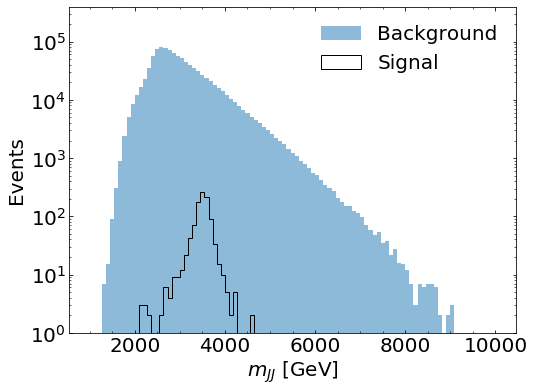

In [10]:
make_plot(1000*dataset_bg[:,0],1000*dataset_sig[:,0][0:1000],np.linspace(1000,10000,100),
          "$m_{JJ}$ [GeV]","mjj",myloc="upper right")

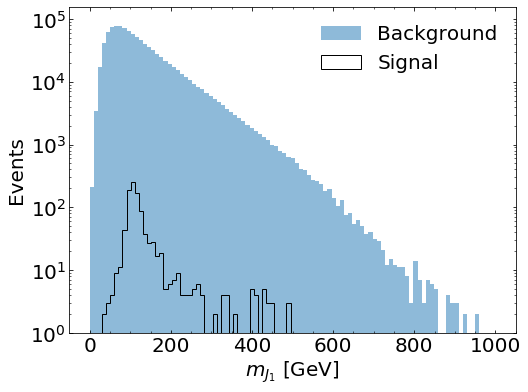

In [11]:
make_plot(1000*dataset_bg[:,1],1000*dataset_sig[:,1][0:1000],np.linspace(0,1000,100),"$m_{J_{1}}$ [GeV]",
          "minmj",2,True,False,"upper right")

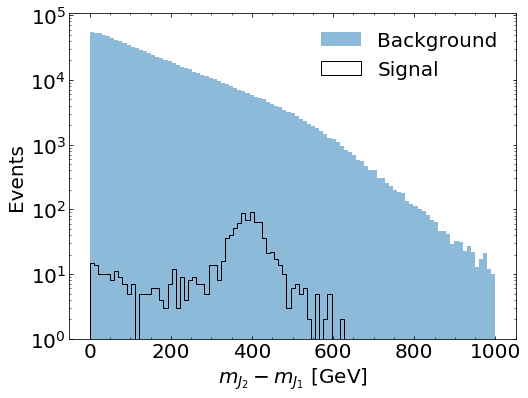

In [12]:
make_plot(1000*dataset_bg[:,2],1000*dataset_sig[:,2][0:1000],np.linspace(0,1000,100),
          "$m_{J_{2}}-m_{J_{1}}$ [GeV]","maxmj",2,True,False,"upper right")

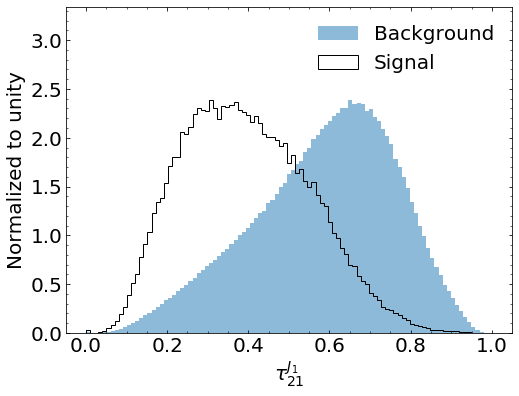

In [13]:
make_plot(dataset_bg[:,3],dataset_sig[:,3],np.linspace(0,1,100),"$\\tau_{21}^{J_{1}}$","mintau21",
          1.4,False,True,"upper right")

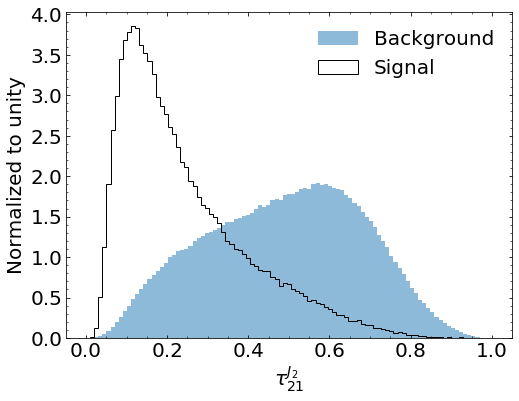

In [14]:
make_plot(dataset_bg[:,4],dataset_sig[:,4],np.linspace(0,1,100),"$\\tau_{21}^{J_{2}}$","maxtau21",2.1,
          False,True,"upper right")

In [8]:
#Make the dataset

dataset_sig_shifted = dataset_sig.copy()
dataset_bg_shifted = dataset_bg.copy()
dataset_bg2_shifted = dataset_bg2.copy()

shift = 0.1

dataset_sig_shifted[:,1] = dataset_sig_shifted[:,1] + shift*dataset_sig_shifted[:,0]
dataset_sig_shifted[:,2] = dataset_sig_shifted[:,2] + shift*dataset_sig_shifted[:,0]

dataset_bg_shifted[:,1] = dataset_bg_shifted[:,1] + shift*dataset_bg_shifted[:,0]
dataset_bg_shifted[:,2] = dataset_bg_shifted[:,2] + shift*dataset_bg_shifted[:,0]

dataset_bg2_shifted[:,1] = dataset_bg2_shifted[:,1] + shift*dataset_bg2_shifted[:,0]
dataset_bg2_shifted[:,2] = dataset_bg2_shifted[:,2] + shift*dataset_bg2_shifted[:,0]

In [23]:
#CWoLa
model_cwola = Sequential()
model_cwola.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(64, activation='relu'))
model_cwola.add(Dense(1, activation='sigmoid'))
model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_sacwola = Sequential()
model_sacwola.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(64, activation='relu'))
model_sacwola.add(Dense(1, activation='sigmoid'))
model_sacwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:1500]
X_sig_inject2 = dataset_sig_shifted[1500:3000]
X_sig_test = dataset_sig_shifted[1500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_background2_inject = dataset_bg2_shifted[0:int(0.5*len(dataset_bg2))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)
                                  *(X_background_inject[:,0] < SR_low)][:,1:5]
X_bg2_SB_low = X_background2_inject[(X_background2_inject[:,0] > SB_low)
                                    *(X_background2_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)
                                   *(X_background_inject[:,0] < SB_high)][:,1:5]
X_bg2_SB_high = X_background2_inject[(X_background2_inject[:,0] > SR_high)
                                     *(X_background2_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

mylambda = 1.0

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                          X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),
                          np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                          np.zeros(len(X_bg2_SR_train)),np.ones(len(X_bg2_SB_low)),np.ones(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),
                          w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),
                          w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                          mylambda*np.ones(len(X_bg2_SR_train)),mylambda*w_low*np.ones(len(X_bg2_SB_low)),
                          mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,
                           X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),
                           np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),
                           np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),
                           w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),
                           w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_sacwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),
                  sample_weight=W_train)

preds_hold = model_sacwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_sacwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_sacwola, tpr_sacwola, _ = roc_curve(Y_test, preds_hold)
fprSB_sacwola, tprSB_sacwola, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)

###

mylambda = 0.

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                         X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),
                          np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                          np.zeros(len(X_bg2_SR_train)),np.ones(len(X_bg2_SB_low)),np.ones(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),
                          w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),
                          w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                          mylambda*np.ones(len(X_bg2_SR_train)),mylambda*w_low*np.ones(len(X_bg2_SB_low)),
                          mylambda*w_high*np.ones(len(X_bg2_SB_high))])

X_testSB = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low_test,X_bg_SB_low_test,X_sig_SB_high_test,X_bg_SB_high_test])
Y_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low_test)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_sig_SB_high_test)),np.zeros(len(X_bg_SB_high_test))])
w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low_test)+len(X_bg_SB_low_test))
w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high_test)+len(X_bg_SB_high_test))
W_testSB = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low_test)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_sig_SB_high_test)),w_high*np.ones(len(X_bg_SB_high_test))])

model_cwola.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

preds_hold = model_cwola.predict(X_test,batch_size=10000)[:,0]
preds_holdSB = model_cwola.predict(X_testSB,batch_size=10000)[:,0]
fpr_cwola, tpr_cwola, _ = roc_curve(Y_test, preds_hold)
fprSB_cwola, tprSB_cwola, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)

Train on 253586 samples, validate on 134826 samples
Epoch 1/10
253586/253586 [==============================] - 7s 28us/step - loss: 0.6757 - acc: 0.5001 - val_loss: 0.6871 - val_acc: 0.7013
Epoch 2/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6756 - acc: 0.5009 - val_loss: 0.6818 - val_acc: 0.8495
Epoch 3/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6756 - acc: 0.5031 - val_loss: 0.6828 - val_acc: 0.5500
Epoch 4/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6756 - acc: 0.5029 - val_loss: 0.6810 - val_acc: 0.5500
Epoch 5/10
253586/253586 [==============================] - 7s 27us/step - loss: 0.6755 - acc: 0.5016 - val_loss: 0.6766 - val_acc: 0.5500
Epoch 6/10
253586/253586 [==============================] - 7s 27us/step - loss: 0.6756 - acc: 0.5008 - val_loss: 0.6816 - val_acc: 0.5500
Epoch 7/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6755 - acc: 0.5025 - val_loss: 

In [24]:
#Optimal CWoLa

model_cwola_optimal = Sequential()
model_cwola_optimal.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(64, activation='relu'))
model_cwola_optimal.add(Dense(1, activation='sigmoid'))
model_cwola_optimal.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Train on 122497 samples, validate on 134826 samples
Epoch 1/10
122497/122497 [==============================] - 4s 35us/step - loss: 0.6931 - acc: 0.5023 - val_loss: 0.6444 - val_acc: 0.5500
Epoch 2/10
122497/122497 [==============================] - 4s 31us/step - loss: 0.6929 - acc: 0.5029 - val_loss: 0.6667 - val_acc: 0.5500
Epoch 3/10
122497/122497 [==============================] - 4s 31us/step - loss: 0.6928 - acc: 0.5028 - val_loss: 0.6400 - val_acc: 0.8318
Epoch 4/10
122497/122497 [==============================] - 4s 31us/step - loss: 0.6927 - acc: 0.5059 - val_loss: 0.6474 - val_acc: 0.5500
Epoch 5/10
122497/122497 [==============================] - 4s 31us/step - loss: 0.6927 - acc: 0.5060 - val_loss: 0.6336 - val_acc: 0.5500
Epoch 6/10
122497/122497 [==============================] - 4s 31us/step - loss: 0.6927 - acc: 0.5046 - val_loss: 0.6625 - val_acc: 0.5503
Epoch 7/10
122497/122497 [==============================] - 4s 31us/step - loss: 0.6926 - acc: 0.5040 - val_loss: 

In [25]:
preds_hold = model_cwola_optimal.predict(X_test,batch_size=10000)[:,0]
fpr_ocwola, tpr_ocwola, _ = roc_curve(Y_test, preds_hold)

In [26]:
#SALAD

model_reweighter = Sequential()
model_reweighter.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(64, activation='relu'))
model_reweighter.add(Dense(1, activation='sigmoid'))
model_reweighter.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_sig_SB_low_long = X_sig_inject[(X_sig_inject[:,0] > SB_low_long)*(X_sig_inject[:,0] < SR_low)][:,0:5]
X_sig_SB_high_long = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high_long)][:,0:5]
X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train_forw = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,0:5]

preds = model_reweighter.predict(np.concatenate([X_sig_SR_train_forw,X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_sig_SR_train_forw)),np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad = Sequential()
model_salad.add(Dense(64, input_dim=4, activation='relu')) 
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(64, activation='relu'))
model_salad.add(Dense(1, activation='sigmoid'))
model_salad.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_datavsim = Sequential()
model_datavsim.add(Dense(64, input_dim=4, activation='relu')) 
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(64, activation='relu'))
model_datavsim.add(Dense(1, activation='sigmoid'))
model_datavsim.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=weights_salad)
model_datavsim.fit(Xs_train,Ys_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test))

Epoch 1/30
361941/361941 [==============================] - 9s 24us/step - loss: 0.6854 - acc: 0.5496
Epoch 2/30
361941/361941 [==============================] - 8s 23us/step - loss: 0.6834 - acc: 0.5561
Epoch 3/30
361941/361941 [==============================] - 9s 24us/step - loss: 0.6827 - acc: 0.5589
Epoch 4/30
361941/361941 [==============================] - 9s 24us/step - loss: 0.6823 - acc: 0.5595
Epoch 5/30
361941/361941 [==============================] - 9s 23us/step - loss: 0.6819 - acc: 0.5603
Epoch 6/30
361941/361941 [==============================] - 8s 23us/step - loss: 0.6816 - acc: 0.5613
Epoch 7/30
361941/361941 [==============================] - 8s 23us/step - loss: 0.6813 - acc: 0.5613
Epoch 8/30
361941/361941 [==============================] - 8s 23us/step - loss: 0.6811 - acc: 0.5621
Epoch 9/30
361941/361941 [==============================] - 8s 23us/step - loss: 0.6812 - acc: 0.5622
Epoch 10/30
361941/361941 [==============================] - 8s 23us/step - loss: 

In [27]:
ww = model_reweighter.predict(X_bg2_SR_train_forw,batch_size=10000)
ww = ww / (1.-ww)

FileNotFoundError: [Errno 2] No such file or directory: 'SA-CWoLa/features1.pdf'

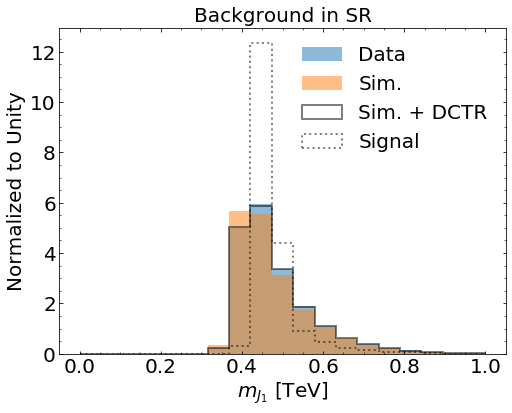

In [28]:
mynames=["$m_{J_1}$ [TeV]","$m_{J_2}-m_{J_1}$ [TeV]",r"$\tau_{21}^{J_1}$",r"$\tau_{21}^{J_2}$"]
for i in range(1,5):
    fig = plt.figure(figsize=(8, 6)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    plt.xlabel(mynames[i-1],fontsize=20)
    plt.ylabel("Normalized to Unity",fontsize=20)
    plt.title("Background in SR",fontsize=20)
    
    if (i==4): plt.ylim([0,4.])
    if (i==2): plt.ylim([0,7.2])
    if (i==3): plt.ylim([0,4])

    plt.hist(X_bg_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Data")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Sim.")
    plt.hist(X_bg2_SR_train_forw[:,i],bins=np.linspace(0,1,20),alpha=0.5,weights=ww,density=True,histtype="step",color="black",label="Sim. + DCTR",linewidth=2)
    plt.hist(X_sig_SR_test[:,i-1],bins=np.linspace(0,1,20),alpha=0.5,density=True,label="Signal",histtype="step",color="black",ls=":",linewidth=2)
    plt.legend(frameon=False,fontsize=20)
    if (i==2): plt.legend(frameon=False,fontsize=20,loc="upper left")
    plt.savefig('SA-CWoLa/features'+str(i)+'.pdf',bbox_inches='tight')

In [ ]:
preds_hold = model_salad.predict(X_test,batch_size=10000)[:,0]
fpr_salad, tpr_salad, _ = roc_curve(Y_test, preds_hold)

In [ ]:
preds_hold = model_datavsim.predict(X_test,batch_size=10000)[:,0]
fpr_datavsim, tpr_datavsim, _ = roc_curve(Y_test, preds_hold)

In [ ]:
#Let's train a fully supervised classifier
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Xfully_train = np.concatenate([X_sig_SR_train,X_bg_SR_train])
#Yfully_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train))])

model.fit(X_test,Y_test, epochs=10, batch_size=200,validation_data=(X_test,Y_test))
preds = model.predict(X_test,batch_size=10000)
fpr_fully, tpr_fully, _ = roc_curve(Y_test, preds)

In [ ]:
#Save the mdoels.

model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("models/model.h5")

model_json = model_sacwola.to_json()
with open("models/model_sacwola.json", "w") as json_file:
    json_file.write(model_json)
model_sacwola.save_weights("models/model_sacwola.h5")

model_json = model_cwola.to_json()
with open("models/model_cwola.json", "w") as json_file:
    json_file.write(model_json)
model_cwola.save_weights("models/model_cwola.h5")

model_json = model_cwola_optimal.to_json()
with open("models/model_cwola_optimal.json", "w") as json_file:
    json_file.write(model_json)
model_cwola_optimal.save_weights("models/model_cwola_optimal.h5")

model_json = model_reweighter.to_json()
with open("models/model_reweighter.json", "w") as json_file:
    json_file.write(model_json)
model_reweighter.save_weights("models/model_reweighter.h5")

model_json = model_salad.to_json()
with open("models/model_salad.json", "w") as json_file:
    json_file.write(model_json)
model_salad.save_weights("models/model_salad.h5")

model_json = model_datavsim.to_json()
with open("models/model_datavsim.json", "w") as json_file:
    json_file.write(model_json)
model_datavsim.save_weights("models/model_datavsim.h5")

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,1./fpr_fully,label="Supervised",color="green")
plt.plot(tpr_datavsim,1./fpr_datavsim,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,1./fpr_salad,label="SALAD",color="blue")
plt.plot(tpr_ocwola,1./fpr_ocwola,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,1./fpr_cwola,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,1./fpr_sacwola,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,1./tpr_fully,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Rejection (1/False Positive Rate)",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc="upper right")
plt.yscale("log")
plt.ylim([1,1e6])
plt.tight_layout()
# plt.savefig('SA-CWoLa/roc_shifted.pdf',bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(tpr_fully,tpr_fully/fpr_fully**0.5,label="Supervised",color="green")
plt.plot(tpr_datavsim,tpr_datavsim/fpr_datavsim**0.5,label="Data vs. Sim.",color="blue",ls=":")
plt.plot(tpr_salad,tpr_salad/fpr_salad**0.5,label="SALAD",color="blue")
plt.plot(tpr_ocwola,tpr_ocwola/fpr_ocwola**0.5,label="Optimal CWoLa",color="red")
plt.plot(tpr_cwola,tpr_cwola/fpr_cwola**0.5,label="CWoLa",color="red",ls=":")
plt.plot(tpr_sacwola,tpr_sacwola/fpr_sacwola**0.5,label="SA-CWoLa",color="orange")
#plt.plot(tprSB_cwola,1./fprSB_cwola,label="CWoLa (SR vs. SB)",color="orange",ls=':')
plt.plot(tpr_fully,tpr_fully/tpr_fully**0.5,color="black",ls=":",label="Random")
plt.xlabel(r'Signal Efficiency (True Positive Rate)',fontsize=20)
plt.ylabel(r"Significance Improvement",fontsize=20)
#plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.tight_layout()
plt.ylim([0,5])
# plt.savefig('SA-CWoLa/sic_shifted.pdf',bbox_inches='tight')

In [31]:
K.clear_session()

In [10]:
SR_low = 3.3
SR_high = 3.7

X_sig_inject = dataset_sig_shifted[0:1500]
X_sig_inject2 = dataset_sig_shifted[1500:3000]
X_sig_test = dataset_sig_shifted[1500:-1]
X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg_SR_test = X_bg_SR[int(0.5*len(X_bg_SR)):-1]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_bg2_SR_test = X_bg2_SR[int(0.5*len(X_bg2_SR)):-1]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]
X_sig_SR_test = X_sig_test[(X_sig_test[:,0] > SR_low)*(X_sig_test[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

X_background_fortest = dataset_bg_shifted[int(0.5*len(dataset_bg)):-1]
X_sig_SB_low_test = X_sig_inject2[(X_sig_inject2[:,0] > SB_low)*(X_sig_inject2[:,0] < SR_low)][:,1:5]
X_bg_SB_low_test = X_background_fortest[(X_background_fortest[:,0] > SB_low)*(X_background_fortest[:,0] < SR_low)][:,1:5]
X_sig_SB_high_test = X_sig_inject2[(X_sig_inject2[:,0] > SR_high)*(X_sig_inject2[:,0] < SB_high)][:,1:5]
X_bg_SB_high_test = X_background_fortest[(X_background_fortest[:,0] > SR_high)*(X_background_fortest[:,0] < SB_high)][:,1:5]


In [32]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx,array[idx]

#Now, a lambda scan, with signal

X_test = np.concatenate([X_sig_SR_test,X_bg_SR_test])
Y_test = np.concatenate([np.ones(len(X_sig_SR_test)),np.zeros(len(X_bg_SR_test))])

lambdas = []
max_sic = []
aucs = []
maxSB_sic = []
aucsSB = []

#mylambda = 0.5
for mylambda in np.linspace(0,2,20):
    
    print(mylambda,"\n\n\n")
    lambdas += [mylambda]
    
    max_sic_foravg = []
    aucs_foravg = []
    maxSB_sic_foravg = []
    aucsSB_foravg = []
    
    for k in range(1):
        
        model_sacwola_scan = Sequential()
        model_sacwola_scan.add(Dense(64, input_dim=4, activation='relu')) 
        model_sacwola_scan.add(Dense(64, activation='relu'))
        model_sacwola_scan.add(Dense(64, activation='relu'))
        model_sacwola_scan.add(Dense(1, activation='sigmoid'))
        model_sacwola_scan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        X_train = np.concatenate([X_sig_SR_train,X_bg_SR_train,X_sig_SB_low,X_bg_SB_low,X_sig_SB_high,X_bg_SB_high,
                                 X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
        Y_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),np.zeros(len(X_sig_SB_low)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_sig_SB_high)),np.zeros(len(X_bg_SB_high)),
                                 np.zeros(len(X_bg2_SR_train)),np.ones(len(X_bg2_SB_low)),np.ones(len(X_bg2_SB_high))])
        w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_low)+len(X_bg_SB_low))
        w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_sig_SB_high)+len(X_bg_SB_high))
        w2_low = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_low)+len(X_bg2_SB_low))
        w2_high = 0.5*(len(X_sig_SR_train)+len(X_bg2_SR_train))/(len(X_sig_SB_high)+len(X_bg2_SB_high))
        W_train = np.concatenate([np.ones(len(X_sig_SR_train)),np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_sig_SB_low)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_sig_SB_high)),w_high*np.ones(len(X_bg_SB_high)),
                                  mylambda*np.ones(len(X_bg2_SR_train)),mylambda*w_low*np.ones(len(X_bg2_SB_low)),mylambda*w_high*np.ones(len(X_bg2_SB_high))])

        X_testSB = np.concatenate([X_bg_SR_train,X_bg_SB_low_test,X_bg_SB_high_test])
        Y_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low_test)),np.zeros(len(X_bg_SB_high_test))])
        w_low = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_low_test))
        w_high = 0.5*(len(X_sig_SR_train)+len(X_bg_SR_train))/(len(X_bg_SB_high_test))
        W_testSB = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low_test)),w_high*np.ones(len(X_bg_SB_high_test))])

        model_sacwola_scan.fit(X_train,Y_train, epochs=10, batch_size=200,validation_data=(X_test,Y_test),sample_weight=W_train)

        preds_hold = model_sacwola_scan.predict(X_test,batch_size=10000)[:,0]
        preds_holdSB = model_sacwola_scan.predict(X_testSB,batch_size=10000)[:,0]
        fpr_sacwola_scan, tpr_sacwola_scan, _ = roc_curve(Y_test, preds_hold)
        fprSB_sacwola_scan, tprSB_sacwola_scan, _ = roc_curve(Y_testSB, preds_holdSB, sample_weight=W_testSB)
        myauc_scan = roc_auc_score(Y_test, preds_hold)
        myaucSB_scan = roc_auc_score(Y_testSB, preds_holdSB)

        mysic = tpr_sacwola_scan[find_nearest(tpr_sacwola_scan,0.5)[0]]/fpr_sacwola_scan[find_nearest(tpr_sacwola_scan,0.5)[0]]**0.5
        mysic_SB = tprSB_sacwola_scan[find_nearest(tprSB_sacwola_scan,0.5)[0]]/fprSB_sacwola_scan[find_nearest(tprSB_sacwola_scan,0.5)[0]]**0.5
        print("   ",k,max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5),myauc_scan,mysic)
        max_sic_foravg += [mysic] #max(tpr_sacwola_scan/(0.000001+fpr_sacwola_scan)**0.5)]
        aucs_foravg += [myauc_scan]
        maxSB_sic_foravg += [mysic_SB] #max(tprSB_sacwola_scan/(0.000001+fprSB_sacwola_scan)**0.5)]
        aucsSB_foravg += [myaucSB_scan]
        pass
    
    max_sic+=[np.mean(max_sic_foravg)]
    aucs+=[np.mean(aucs_foravg)]
    maxSB_sic+=[np.mean(maxSB_sic_foravg)]
    aucsSB+=[np.mean(aucsSB_foravg)]

0.0 



Train on 253586 samples, validate on 134826 samples
Epoch 1/10
253586/253586 [==============================] - 7s 27us/step - loss: 0.6751 - acc: 0.5000 - val_loss: 0.6851 - val_acc: 0.5518
Epoch 2/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6750 - acc: 0.5025 - val_loss: 0.6848 - val_acc: 0.7728
Epoch 3/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6749 - acc: 0.5013 - val_loss: 0.6774 - val_acc: 0.7529
Epoch 4/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6748 - acc: 0.5014 - val_loss: 0.6584 - val_acc: 0.8397
Epoch 5/10
253586/253586 [==============================] - 6s 25us/step - loss: 0.6743 - acc: 0.4999 - val_loss: 0.6311 - val_acc: 0.6354
Epoch 6/10
253586/253586 [==============================] - 6s 25us/step - loss: 0.6712 - acc: 0.5007 - val_loss: 0.6294 - val_acc: 0.8073
Epoch 7/10
253586/253586 [==============================] - 7s 26us/step - loss: 0.6653 - acc: 0.4990 - va

253586/253586 [==============================] - 7s 28us/step - loss: 0.6933 - acc: 0.5026 - val_loss: 0.6809 - val_acc: 0.5500
Epoch 9/10
253586/253586 [==============================] - 7s 28us/step - loss: 0.6933 - acc: 0.5020 - val_loss: 0.6750 - val_acc: 0.5500
Epoch 10/10
253586/253586 [==============================] - 7s 28us/step - loss: 0.6933 - acc: 0.5037 - val_loss: 0.6784 - val_acc: 0.5500
    0 3.0875412961319126 0.882859025450895 3.061370504054355
1.1578947368421053 



Train on 253586 samples, validate on 134826 samples
Epoch 1/10
253586/253586 [==============================] - 8s 31us/step - loss: 0.7290 - acc: 0.5027 - val_loss: 0.6740 - val_acc: 0.7493
Epoch 2/10
253586/253586 [==============================] - 7s 28us/step - loss: 0.7289 - acc: 0.5016 - val_loss: 0.6830 - val_acc: 0.5500
Epoch 3/10
253586/253586 [==============================] - 7s 28us/step - loss: 0.7289 - acc: 0.5014 - val_loss: 0.6838 - val_acc: 0.5500
Epoch 4/10
253586/253586 [==============

(0, 1)

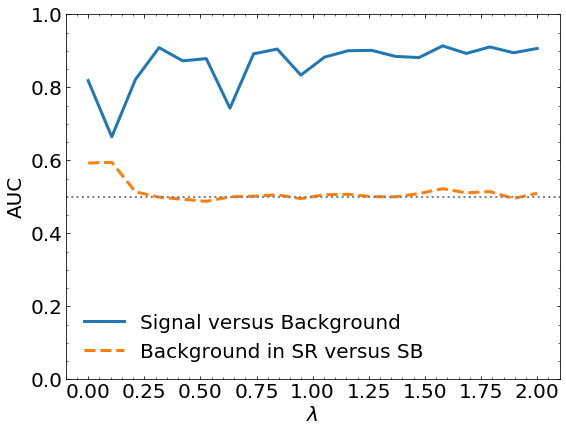

In [33]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,aucs,label="Signal versus Background",linewidth=3)
plt.plot(lambdas,aucsSB,label="Background in SR versus SB",ls="--",linewidth=3)
plt.axhline(0.5,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"AUC",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0,1])
# plt.savefig('SA-CWoLa/lambdascan_AUC.pdf',bbox_inches='tight')

(0.2, 5)

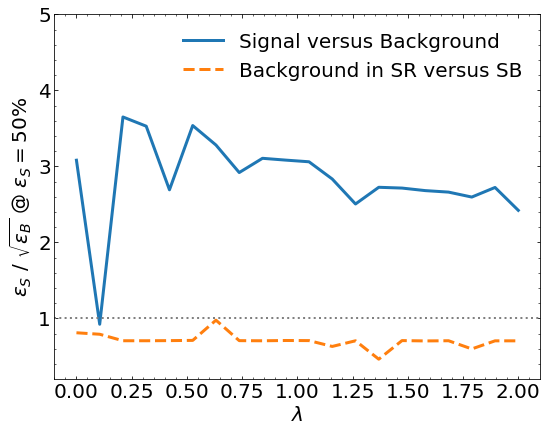

In [34]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(lambdas,max_sic,label="Signal versus Background",linewidth=3)
plt.plot(lambdas,maxSB_sic,label="Background in SR versus SB",ls="--",linewidth=3)
plt.axhline(1.,linewidth=2, color='gray',ls=":")

plt.xlabel(r'$\lambda$',fontsize=20)
plt.ylabel(r"$\epsilon_S$ / $\sqrt{\epsilon_B}$ @ $\epsilon_S = 50\%$",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.tight_layout()
plt.ylim([0.2,5])
# plt.savefig('SA-CWoLa/lambdascan_sic.pdf',bbox_inches='tight')

In [315]:
#Try a fit.

In [40]:
n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],1000*dataset_sig[:,0][0:0]]),
                 np.linspace(2600,5000,30))

In [41]:
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
#myout = get_fit_params(n,b,n**0.5,[28],verbose=False,npar=4)

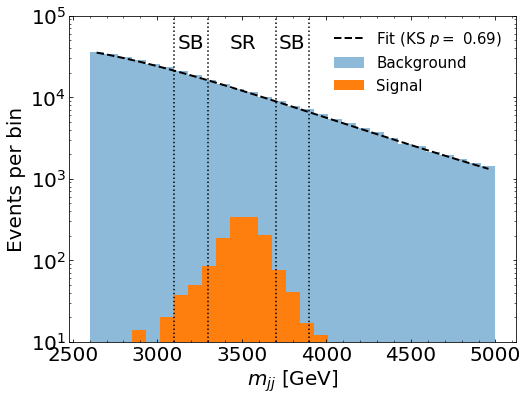

In [42]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel("$m_{jj}$ [GeV]",fontsize=20)
plt.ylabel("Events per bin",fontsize=20)

_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30),alpha=0.5,label="Background")
_,_,_=plt.hist(1000*dataset_sig[0:1500][:,0],np.linspace(2600,5000,30),label="Signal")
#_,_,_=plt.hist(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)],np.linspace(2600,5000,30))
plt.plot(0.5*(b[ 1:]+b[:-1]) ,80*myout['ydata_fit']/100,color="black",ls='--',linewidth=2,label="Fit (KS $p =$ "+"%0.2f" % myout["fit_p0"]+")")
plt.ylim(10,1e5)
plt.axvline(x=SR_low*1000,color="black",ls=":")
plt.axvline(x=SR_high*1000,color="black",ls=":")
plt.axvline(x=SB_low*1000,color="black",ls=":")
plt.axvline(x=SB_high*1000,color="black",ls=":")
plt.text(3430,4e4,"SR",fontsize=20)
plt.text(3720,4e4,"SB",fontsize=20)
plt.text(3120,4e4,"SB",fontsize=20)
plt.legend(frameon=False,fontsize=15)
plt.yscale("log")
# plt.savefig('SA-CWoLa/mjjfit.pdf',bbox_inches='tight')

In [43]:
print("mean",np.mean(myout['residuals']))
print("std",np.std(myout['residuals']))

mean -0.10745200516651034
std 1.2487176603437526


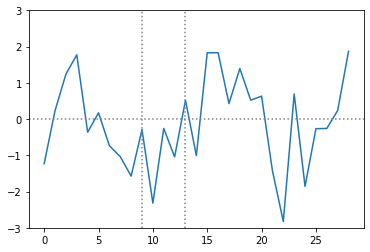

In [44]:
plt.plot(myout['residuals'])
plt.ylim([-3,3])
plt.axhline(y=0,color="gray",ls=":")
plt.axvline(x=9,color="gray",ls=":")
plt.axvline(x=13,color="gray",ls=":")

mean -0.011794759525631658
std 0.12457789130384485


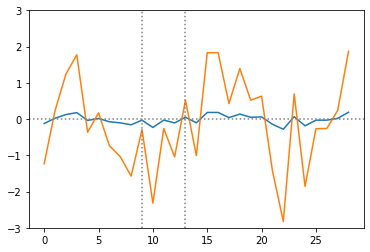

In [45]:
n2 = n-0.9*myout['residuals']*n**0.5
myout2 = get_fit_params(n2,b,n**0.5,range(9,14),verbose=False)
print("mean",np.mean(myout2['residuals']))
print("std",np.std(myout2['residuals']))
plt.plot(myout2['residuals'])
plt.plot(myout['residuals'])
plt.ylim([-3,3])
plt.axhline(y=0,color="gray",ls=":")
plt.axvline(x=9,color="gray",ls=":")
plt.axvline(x=13,color="gray",ls=":")

In [344]:
myout['Zval']

14.621732407416205

In [46]:
B = len(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)])
S = len(dataset_sig[0:int(500)][:,0][(dataset_sig[0:int(500)][:,0] > SR_low)*(dataset_sig[0:int(500)][:,0] < SR_high)])
print(S/B,S/B**0.5)

0.006476941425921018 1.591378049847087


In [47]:
fitvals = []
injectvals = []
n,b=np.histogram(1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],np.linspace(2600,5000,30))
myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
mycor = myout['residuals']*n**0.5
for s in np.linspace(0,10,20):
    mult = 310.
    B = len(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0][(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] > SR_low)*(dataset_bg[int(0.5*len(dataset_bg)):-1][:,0] < SR_high)])
    S = len(dataset_sig[0:int(s*mult)][:,0][(dataset_sig[0:int(s*mult)][:,0] > SR_low)*(dataset_sig[0:int(s*mult)][:,0] < SR_high)])
    n,b=np.histogram(np.concatenate([1000*dataset_bg[int(0.5*len(dataset_bg)):-1][:,0],1000*dataset_sig[0:int(s*mult)][:,0]]),np.linspace(2600,5000,30))
    n = n - 0.99*mycor
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    print(s,S/B**0.5,myout['Zval'])
    injectvals+=[S/B**0.5]
    fitvals+=[myout['Zval']]

0.0 0.0 0
0.5263157894736842 0.5291026764197476 0.3592945153227749
1.0526315789473684 1.0297152087245858 0.6802287360114024
1.5789473684210527 1.5547478645564892 1.0378801115084626
2.1052631578947367 2.0919905821519253 1.3992062017981968
2.631578947368421 2.5600429497540094 1.6973934070610395
3.1578947368421053 3.07286554382238 2.040212149499455
3.6842105263157894 3.569408055539374 2.351601532104433
4.2105263157894735 4.070020587844212 2.6813771003078766
4.7368421052631575 4.578773161324738 3.020208737121444
5.263157894736842 5.059035590690356 3.352729038666838
5.789473684210526 5.551508081819506 3.685433873063736
6.315789473684211 6.052120614124344 4.0217704254358395
6.842105263157895 6.552733146429182 4.3829631944993155
7.368421052631579 7.028925555206954 4.7536178245860095
7.894736842105263 7.5458181698631694 5.146978684678676
8.421052631578947 8.034220640404476 5.497318565947188
8.947368421052632 8.53076315212147 5.852564643826711
9.473684210526315 9.063935849129061 6.2772369926668

Text(0, 0.5, 'Fitted significance')

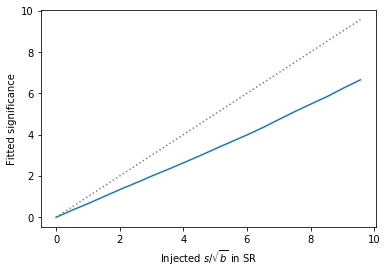

In [48]:
plt.plot(injectvals,fitvals)
plt.plot(injectvals,injectvals,ls=":",color="gray")
plt.xlabel(r"Injected $s/\sqrt{b}$ in SR")
plt.ylabel(r"Fitted significance")

In [11]:
X_sig_test_all = dataset_sig_shifted[1500:3000]
X_sig_SR_test_all = X_sig_test_all[:,1:5]
M_sig_SR_test_all = X_sig_test_all[:,0]
X_bg_SR_all = dataset_bg_shifted[:,0:5]
X_bg_SR_test_all = X_bg_SR_all[int(0.5*len(X_bg_SR)):-1][:,1:5]
M_bg_SR_test_all = X_bg_SR_all[int(0.5*len(X_bg_SR)):-1][:,0]

X_test_all = np.concatenate([X_sig_SR_test_all,X_bg_SR_test_all])
Y_test_all = np.concatenate([np.ones(len(X_sig_SR_test_all)),np.zeros(len(X_bg_SR_test_all))])
M_test_all = np.concatenate([M_sig_SR_test_all,M_bg_SR_test_all])

In [66]:
# Load models
with open('models/model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights('models/model.h5')
    
with open('models/model_cwola.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model_cwola = model_from_json(loaded_model_json)
    model_cwola.load_weights('models/model_cwola.h5')
    
with open('models/model_cwola_optimal.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model_cwola_optimal = model_from_json(loaded_model_json)
    model_cwola_optimal.load_weights('models/model_cwola_optimal.h5')
    
with open('models/model_datavsim.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model_datavsim = model_from_json(loaded_model_json)
    model_datavsim.load_weights('models/model_datavsim.h5')
    
with open('models/model_sacwola.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model_sacwola = model_from_json(loaded_model_json)
    model_sacwola.load_weights('models/model_sacwola.h5')
    
with open('models/model_salad.json', 'r') as json_file:
    loaded_model_json = json_file.read()
    model_salad = model_from_json(loaded_model_json)
    model_salad.load_weights('models/model_salad.h5')

In [67]:
preds_fully_all = model.predict(X_test_all,batch_size=10000)
preds_optimal_cwola = model_cwola_optimal.predict(X_test_all,batch_size=10000)
preds_sacwola = model_sacwola.predict(X_test_all,batch_size=10000)
preds_cwola = model_cwola.predict(X_test_all,batch_size=10000)
preds_salad = model_salad.predict(X_test_all,batch_size=10000)
preds_datavsim = model_datavsim.predict(X_test_all,batch_size=10000)

(array([4.26085209e+01, 6.07435996e-01, 1.95754230e-01, 1.22707755e-01,
        8.15256533e-02, 5.40864477e-02, 3.49395657e-02, 2.20817480e-02,
        1.17862802e-02, 4.79836702e-03]),
 array([0.5001176 , 0.52297807, 0.54583853, 0.56869906, 0.5915595 ,
        0.61442   , 0.63728046, 0.66014093, 0.68300146, 0.7058619 ,
        0.7287224 ], dtype=float32),
 <a list of 10 Patch objects>)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f1114156dd8>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94276913700544
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7f1114156a58>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, st

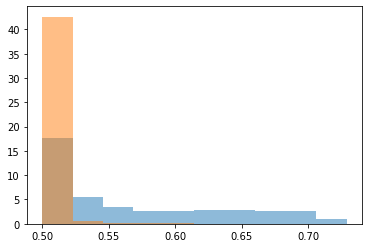

In [68]:
n,b,_=plt.hist(preds_optimal_cwola[Y_test_all==1][:,0],density=True,alpha=0.5)
plt.hist(preds_optimal_cwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)

(array([6.37644168e-02, 1.06834034e+00, 1.13433989e+02, 8.84179777e+01,
        3.63009706e+00, 1.78741728e+00, 9.58268133e-01, 4.96243777e-01,
        2.16127813e-01, 6.06321297e-02]),
 array([0.484628  , 0.4893869 , 0.49414575, 0.49890465, 0.50366354,
        0.50842243, 0.5131813 , 0.51794016, 0.52269906, 0.52745795,
        0.53221685], dtype=float32),
 <a list of 10 Patch objects>)

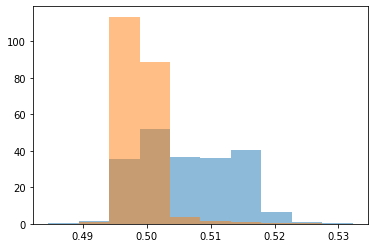

In [69]:
n,b,_=plt.hist(preds_sacwola[Y_test_all==1][:,0],density=True,alpha=0.5)
plt.hist(preds_sacwola[Y_test_all==0][:,0],density=True,bins=b,alpha=0.5)

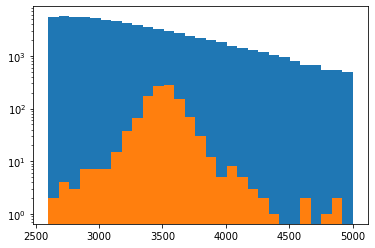

In [70]:
q = np.quantile(preds_optimal_cwola[Y_test_all==0],0.9)
plt.hist(1000*M_test_all[(Y_test_all==0) * (preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
plt.hist(1000*M_test_all[(Y_test_all==1) * (preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
plt.yscale('log')

In [71]:
cutval = []
sigval_fit = []
sigval_fit_sacwola = []
sigval_fit_cwola = []
sigval_fit_salad = []
sigval_fit_datavsim = []
sigval = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_sacwola+=[myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
    n = n-0.*myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_salad+=[myout['Zval']]    
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

0.01 0.37468923293318257 0.3539458003760445 3.3452380952380953
0.2928932188134524 0.6897592403620487 0.24517280241383532 3.7458729936868407
0.5 1.1035839683122373 0.13488682434385013 4.241003764522694
0.6464466094067263 0.7691376235778875 0.22090580757491574 4.837435686058209
0.75 0.7972847592689788 0.2126428348418259 5.501500294636142
0.8232233047033631 1.4955942707797678 0.06737970852592368 6.2119947017218635
0.875 2.1361929619766244 0.016331844441577203 6.919781645116108
0.9116116523516815 3.1043026139672025 0.00095364071873838 7.83374216735977
0.9375 3.027825379028873 0.001231601887845657 8.661701200269114
0.9558058261758408 4.465602994270749 3.992177484146708e-06 9.699422038389086
0.96875 6.3363082699993365 1.1766787544331692e-10 10.888473136258202
0.9779029130879204 5.918703745965675 1.6224442900281133e-09 12.012083725999187
0.984375 7.245482796398428 2.1549428907974288e-13 12.951114536261647
0.9889514565439602 6.4669787040994695 4.9990900308216624e-11 13.942472519767646
0.992187

Text(0, 0.5, 'SR excess [units of $\\sigma$]')

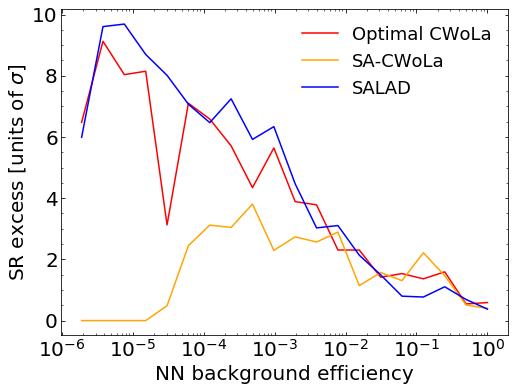

In [72]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
# plt.savefig('SA-CWoLa/fitwithsig.pdf',bbox_inches='tight')

In [706]:
cutval = []
sigval2_fit = []
sigval2_fit_sacwola = []
sigval2_fit_cwola = []
sigval2_fit_salad = []
sigval2_fit_datavsim = []
sigval2 = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
    q = np.quantile(preds_optimal_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_optimal_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    
    B = len(M_test_all[(Y_test_all==0)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    S = len(M_test_all[(Y_test_all==1)*(preds_optimal_cwola[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
    
    cutval+=[2**(-myqexp)] #myq]
    sigval2_fit+=[myout['Zval']]
    sigval+=[S/B**0.5]
    
    q = np.quantile(preds_sacwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_sacwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_sacwola+=[myout['Zval']]
    
    q = np.quantile(preds_salad[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_salad[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_salad+=[myout['Zval']]    
    
    '''
    q = np.quantile(preds_datavsim[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_datavsim[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_datavsim[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_datavsim+=[myout['Zval']]  
    '''
    
    '''
    q = np.quantile(preds_cwola[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_cwola[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    n,b=np.histogram(1000*M_test_all[preds_cwola[:,0]>q],np.linspace(2600,5000,30))
    n = n-myout['residuals']*n**0.5
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)  
    sigval2_fit_cwola+=[myout['Zval']]     
    '''
    
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

0.01 2.175526655212908 0.014795336437885553 3.3472112805514422
0.2928932188134524 2.423735172295676 0.007680901664200435 3.831361026499784
0.5 3.0398624521390416 0.0011834310826656091 4.264121949506649
0.6464466094067263 3.953902587790177 3.844336128477899e-05 4.848981088155985
0.75 4.963348583562373 3.4644031299269074e-07 5.544313495090207
0.8232233047033631 5.399184954512034 3.347216548377219e-08 6.322044582216891
0.875 5.4552996116450245 2.4445169555242785e-08 7.147179680507276
0.9116116523516815 7.0120797156718035 1.174060848541103e-12 7.930865857988218
0.9375 7.433484531208128 5.284661597215745e-14 8.996750094806602
0.9558058261758408 7.493861421903891 3.341771304121721e-14 10.008320271373108
0.96875 7.687919866879595 7.438494264988549e-15 11.112283725869387
0.9779029130879204 7.363022684247284 8.992806499463768e-14 11.709738644126325
0.984375 7.852221415223271 1.9984014443252818e-15 12.624859247909622
0.9889514565439602 6.917930083576533 2.291500322826323e-12 12.810027023650328
0

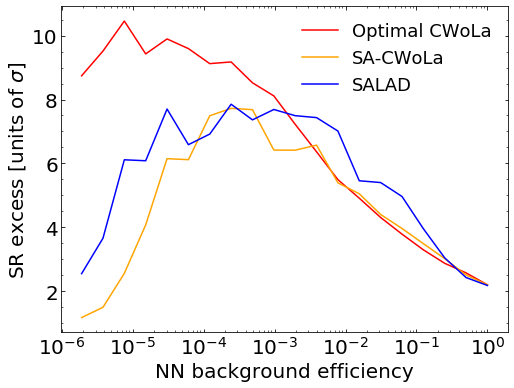

In [707]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval,sigval2_fit,label="Optimal CWoLa",color='red')
plt.plot(cutval,sigval2_fit_sacwola,label="SA-CWoLa",color='orange')
plt.plot(cutval,sigval2_fit_salad,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
plt.savefig('SA-CWoLa/fitwithsig_optimal.pdf',bbox_inches='tight')

In [ ]:
#Now, do a training with no signal and run the same fit?

In [102]:
#CWoLa
model_sacwola_NO = Sequential()
model_sacwola_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(64, activation='relu'))
model_sacwola_NO.add(Dense(1, activation='sigmoid'))
model_sacwola_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SR_low = 3.3
SR_high = 3.7

X_bg_SR = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,1:5]
X_bg_SR_train = X_bg_SR[0:int(0.5*len(X_bg_SR))]
X_bg2_SR = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,1:5]
X_bg2_SR_train = X_bg2_SR[0:int(0.5*len(X_bg2_SR))]
X_sig_SR_train = X_sig_inject[(X_sig_inject[:,0] > SR_low)*(X_sig_inject[:,0] < SR_high)][:,1:5]

SB_low = 3.1
SB_high = 3.9

X_background_inject = dataset_bg_shifted[0:int(0.5*len(dataset_bg))]
X_sig_SB_low = X_sig_inject[(X_sig_inject[:,0] > SB_low)*(X_sig_inject[:,0] < SR_low)][:,1:5]
X_bg_SB_low = X_background_inject[(X_background_inject[:,0] > SB_low)*(X_background_inject[:,0] < SR_low)][:,1:5]
X_sig_SB_high = X_sig_inject[(X_sig_inject[:,0] > SR_high)*(X_sig_inject[:,0] < SB_high)][:,1:5]
X_bg_SB_high = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high)][:,1:5]

mylambda = 1.0

X_train = np.concatenate([X_bg_SR_train,X_bg_SB_low,X_bg_SB_high,X_bg2_SR_train,X_bg2_SB_low,X_bg2_SB_high])
Y_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SB_low)),np.zeros(len(X_bg_SB_high)),
                         np.zeros(len(X_bg2_SR_train)),np.ones(len(X_bg2_SB_low)),np.ones(len(X_bg2_SB_high))])
w_low = 0.5*(len(X_bg_SR_train))/(len(X_bg_SB_low))
w_high = 0.5*(len(X_bg_SR_train))/(len(X_bg_SB_high))
w2_low = 0.5*(len(X_bg2_SR_train))/(len(X_bg2_SB_low))
w2_high = 0.5*(len(X_bg2_SR_train))/(len(X_bg2_SB_high))
W_train = np.concatenate([np.ones(len(X_bg_SR_train)),w_low*np.ones(len(X_bg_SB_low)),w_high*np.ones(len(X_bg_SB_high)),
                          mylambda*np.ones(len(X_bg2_SR_train)),mylambda*w_low*np.ones(len(X_bg2_SB_low)),
                          mylambda*w_high*np.ones(len(X_bg2_SB_high))])

model_sacwola_NO.fit(X_train,Y_train, epochs=10, batch_size=200,sample_weight=W_train)

Epoch 1/10
252213/252213 [==============================] - 9s 34us/step - loss: 0.6706 - acc: 0.4989
Epoch 2/10
252213/252213 [==============================] - 7s 26us/step - loss: 0.6705 - acc: 0.4996
Epoch 3/10
252213/252213 [==============================] - 7s 27us/step - loss: 0.6705 - acc: 0.4996
Epoch 4/10
252213/252213 [==============================] - 7s 27us/step - loss: 0.6705 - acc: 0.4999
Epoch 5/10
252213/252213 [==============================] - 6s 26us/step - loss: 0.6705 - acc: 0.5009
Epoch 6/10
252213/252213 [==============================] - 7s 26us/step - loss: 0.6705 - acc: 0.4995
Epoch 7/10
252213/252213 [==============================] - 7s 26us/step - loss: 0.6705 - acc: 0.5004
Epoch 8/10
252213/252213 [==============================] - 7s 26us/step - loss: 0.6705 - acc: 0.4991
Epoch 9/10
252213/252213 [==============================] - 7s 26us/step - loss: 0.6705 - acc: 0.4995
Epoch 10/10
252213/252213 [==============================] - 7s 26us/step - loss: 

In [74]:
#Optimal CWoLa

model_cwola_optimal_NO = Sequential()
model_cwola_optimal_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(64, activation='relu'))
model_cwola_optimal_NO.add(Dense(1, activation='sigmoid'))
model_cwola_optimal_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_train = np.concatenate([X_bg_SR_train,X_bg_SR_test])
Y_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg_SR_test))])

model_cwola_optimal_NO.fit(X_train,Y_train, epochs=10, batch_size=200)

Epoch 1/10
121351/121351 [==============================] - 5s 40us/step - loss: 0.6933 - acc: 0.5014
Epoch 2/10
121351/121351 [==============================] - 3s 26us/step - loss: 0.6932 - acc: 0.4995
Epoch 3/10
121351/121351 [==============================] - 3s 25us/step - loss: 0.6932 - acc: 0.5005
Epoch 4/10
121351/121351 [==============================] - 3s 26us/step - loss: 0.6932 - acc: 0.4990
Epoch 5/10
121351/121351 [==============================] - 3s 25us/step - loss: 0.6932 - acc: 0.5027
Epoch 6/10
121351/121351 [==============================] - 3s 26us/step - loss: 0.6932 - acc: 0.5019
Epoch 7/10
121351/121351 [==============================] - 3s 26us/step - loss: 0.6932 - acc: 0.4999
Epoch 8/10
121351/121351 [==============================] - 3s 26us/step - loss: 0.6932 - acc: 0.4977
Epoch 9/10
121351/121351 [==============================] - 3s 26us/step - loss: 0.6931 - acc: 0.4998
Epoch 10/10
121351/121351 [==============================] - 3s 26us/step - loss: 

In [75]:
#SALAD

model_reweighter_NO = Sequential()
model_reweighter_NO.add(Dense(64, input_dim=5, activation='relu')) 
model_reweighter_NO.add(Dense(64, activation='relu'))
model_reweighter_NO.add(Dense(64, activation='relu'))
model_reweighter_NO.add(Dense(1, activation='sigmoid'))
model_reweighter_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

SB_low_long = 3.1-0.3
SB_high_long = 3.9+0.3

X_bg_SB_low_long = X_background_inject[(X_background_inject[:,0] > SB_low_long)*(X_background_inject[:,0] < SR_low)][:,0:5]
X_bg_SB_high_long = X_background_inject[(X_background_inject[:,0] > SR_high)*(X_background_inject[:,0] < SB_high_long)][:,0:5]
X_bg2_SB_low_long = X_background2_inject[(X_background2_inject[:,0] > SB_low_long)*(X_background2_inject[:,0] < SR_low)][:,0:5]
X_bg2_SB_high_long = X_background2_inject[(X_background2_inject[:,0] > SR_high)*(X_background2_inject[:,0] < SB_high_long)][:,0:5]

Xs_train_rw = np.concatenate([X_bg_SB_low_long,X_bg_SB_high_long,X_bg2_SB_low_long,X_bg2_SB_high_long])
Ys_train_rw = np.concatenate([np.ones(len(X_bg_SB_low_long)),np.ones(len(X_bg_SB_high_long)),np.zeros(len(X_bg2_SB_low_long)),np.zeros(len(X_bg2_SB_high_long))])

model_reweighter_NO.fit(Xs_train_rw,Ys_train_rw, epochs=30, batch_size=200)

X_bg_SR_forw = dataset_bg_shifted[(dataset_bg_shifted[:,0] > SR_low)*(dataset_bg_shifted[:,0] < SR_high)][:,0:5]
X_bg_SR_train_forw = X_bg_SR_forw[0:int(0.5*len(X_bg_SR))]
X_bg2_SR_forw = dataset_bg2_shifted[(dataset_bg2_shifted[:,0] > SR_low)*(dataset_bg2_shifted[:,0] < SR_high)][:,0:5]
X_bg2_SR_train_forw = X_bg2_SR_forw[0:int(0.5*len(X_bg2_SR))]

preds = model_reweighter_NO.predict(np.concatenate([X_bg_SR_train_forw,X_bg2_SR_train_forw]),batch_size=10000)
weights_salad = preds / (1.-preds)
weights_salad = weights_salad[:,0]
isdata = np.concatenate([np.ones(len(X_bg_SR_train_forw)),np.zeros(len(X_bg2_SR_train_forw))])
weights_salad[isdata==1]=1.

model_salad_NO = Sequential()
model_salad_NO.add(Dense(64, input_dim=4, activation='relu')) 
model_salad_NO.add(Dense(64, activation='relu'))
model_salad_NO.add(Dense(64, activation='relu'))
model_salad_NO.add(Dense(1, activation='sigmoid'))
model_salad_NO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Xs_train = np.concatenate([X_bg_SR_train,X_bg2_SR_train])
Ys_train = np.concatenate([np.ones(len(X_bg_SR_train)),np.zeros(len(X_bg2_SR_train))])

model_salad_NO.fit(Xs_train,Ys_train, epochs=10, batch_size=200,sample_weight=weights_salad)

Epoch 1/30
361941/361941 [==============================] - 11s 31us/step - loss: 0.6861 - acc: 0.5474
Epoch 2/30
361941/361941 [==============================] - 9s 25us/step - loss: 0.6836 - acc: 0.5564
Epoch 3/30
361941/361941 [==============================] - 9s 25us/step - loss: 0.6825 - acc: 0.5589
Epoch 4/30
361941/361941 [==============================] - 9s 26us/step - loss: 0.6820 - acc: 0.5594
Epoch 5/30
361941/361941 [==============================] - 9s 26us/step - loss: 0.6816 - acc: 0.5607
Epoch 6/30
361941/361941 [==============================] - 9s 26us/step - loss: 0.6814 - acc: 0.5611
Epoch 7/30
361941/361941 [==============================] - 9s 26us/step - loss: 0.6814 - acc: 0.5616
Epoch 8/30
361941/361941 [==============================] - 9s 26us/step - loss: 0.6811 - acc: 0.5618
Epoch 9/30
361941/361941 [==============================] - 9s 26us/step - loss: 0.6811 - acc: 0.5617
Epoch 10/30
361941/361941 [==============================] - 9s 26us/step - loss:

In [76]:
#Save models
model_json = model_cwola_optimal_NO.to_json()
with open("models/model_cwola_optimal_NO.json", "w") as json_file:
    json_file.write(model_json)
model_cwola_optimal_NO.save_weights("models/model_cwola_optimal_NO.h5")

model_json = model_sacwola_NO.to_json()
with open("models/model_sacwola_NO.json", "w") as json_file:
    json_file.write(model_json)
model_sacwola_NO.save_weights("models/model_sacwola_NO.h5")

model_json = model_salad_NO.to_json()
with open("models/model_salad_NO.json", "w") as json_file:
    json_file.write(model_json)
model_salad_NO.save_weights("models/model_salad_NO.h5")

In [6]:
#Load models
with open("models/model_cwola_optimal_NO.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_cwola_optimal_NO = model_from_json(loaded_model_json)
    model_cwola_optimal_NO.load_weights('models/model_cwola_optimal_NO.h5')
    
with open("models/model_sacwola_NO.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_sacwola_NO = model_from_json(loaded_model_json)
    model_sacwola_NO.load_weights('models/model_sacwola_NO.h5')
    
with open("models/model_salad_NO.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_salad_NO = model_from_json(loaded_model_json)
    model_salad_NO.load_weights('models/model_salad_NO.h5')

In [ ]:
#Generate test data without signal
X_test_all_NO = 

In [12]:
#preds_fully_all_NO = model_NO.predict(X_test_all,batch_size=10000)
preds_optimal_cwola_NO = model_cwola_optimal_NO.predict(X_test_all,batch_size=10000)
preds_sacwola_NO = model_sacwola_NO.predict(X_test_all,batch_size=10000)
#preds_cwola_NO = model_cwola_NO.predict(X_test_all,batch_size=10000)
preds_salad_NO = model_salad_NO.predict(X_test_all,batch_size=10000)
#preds_datavsim_NO = model_datavsim_NO.predict(X_test_all,batch_size=10000)

In [20]:
cutval_NO = []
sigval_fit_NO = []
sigval_fit_sacwola_NO = []
sigval_fit_cwola_NO = []
sigval_fit_salad_NO = []
sigval_fit_datavsim_NO = []
sigval_NO = []
for myqexp in range(20):
    myq = 1.-2**(-myqexp/2)
    if (myq==0):
        myq = 0.01
        
    try:
        q = np.quantile(preds_optimal_cwola_NO[Y_test_all==0],myq)
        n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_optimal_cwola_NO[:,0]>q)],np.linspace(2600,5000,30))
        myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)

        B = len(M_test_all[(Y_test_all==0)
                           *(preds_optimal_cwola_NO[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])
        S = len(M_test_all[(Y_test_all==1)
                           *(preds_optimal_cwola_NO[:,0]>q)*(M_test_all > SR_low)*(M_test_all < SR_high)])

        cutval_NO+=[2**(-myqexp)] #myq]
        sigval_fit_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']
        #sigval_NO+=[S/B**0.5]
    except TypeError:
        sigval_fit_NO += [float('nan')]
        
    q = np.quantile(preds_sacwola_NO[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_sacwola_NO[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_sacwola_NO+=[myout['sr_excess']
                            /(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5] #myout['Zval']]
    
    q = np.quantile(preds_salad_NO[Y_test_all==0],myq)
    n,b=np.histogram(1000*M_test_all[(Y_test_all==0)*(preds_salad_NO[:,0]>q)],np.linspace(2600,5000,30))
    myout = get_fit_params(n,b,n**0.5,range(9,14),verbose=False)
    sigval_fit_salad_NO+=[myout['sr_excess']/(myout['std_dev_sys']**2+myout['std_dev_stat']**2)**0.5]
    print(myq,myout['Zval'],myout['p0'],S/B**0.5)

0.01 0 0.5 2.2705596257611615
0.2928932188134524 0 0.5 0.8625965923293422
0.5 0.2898838889647934 0.3859525337115739 0.6559406300662438
0.6464466094067263 0 0.5 0.6215521401066002
0.75 0.22372899241274635 0.4114840925189578 0.5446678339832612
0.8232233047033631 0.9779003825111208 0.16406179797138676 0.37796447300922725
0.875 1.7422550883681909 0.04073190917873404 0.34025229225609716
0.9116116523516815 1.0861087890675167 0.13871543216381665 0.27158776019568004
0.9375 1.825156539727176 0.03398870503216023 0.23391886332130657
0.9558058261758408 0.9695874537803165 0.16612608456154532 0.24248610270298646
0.96875 1.2374718897755435 0.10795597201096196 0.17338209161632448
0.9779029130879204 1.326911178627391 0.09226903303995204 0.09020771689863956
0.984375 1.589414803381918 0.055983387329675116 0.10954451150103321
0.9889514565439602 1.3621643272166823 0.08657301549810548 0.04428074427700476


../ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.9921875 0.948958609692371 0.17132083181736246 0.0524863881081478


../ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.99447572827198 0.09228351545199769 0.4632363926203037 0.06337242505244779


../ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.99609375 0 0.5 0.07537783614444091


../ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.99723786413599 1.2790605908430526 0.10043785997364463 0.0


../ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.998046875 1.480058705221867 0.06942879032449834 0.0


../ATLAS_anomaly_detection/fit_utils.py:158: RuntimeWarning: divide by zero encountered in true_divide
  res_unc = 1 / np.sqrt(ydata)


0.998618932067995 0.7310647778710114 0.23236979350118248 0.0


Text(0, 0.5, 'SR excess [units of $\\sigma$]')

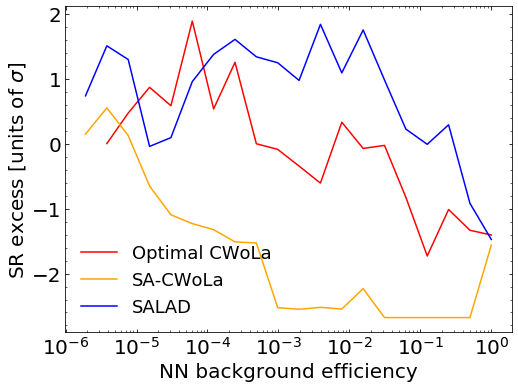

In [21]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO,label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO,label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO,label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("SR excess [units of $\sigma$]",fontsize=20)
# plt.savefig('SA-CWoLa/fitnosig_optimal.pdf',bbox_inches='tight')

Text(0, 0.5, '$Shifted$ SR excess [units of $\\sigma$]')

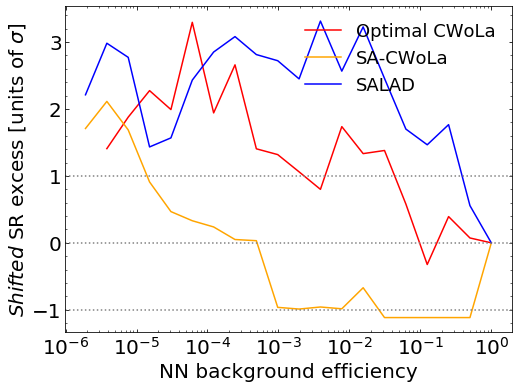

In [22]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.plot(cutval_NO,sigval_fit_NO-sigval_fit_NO[0],label="Optimal CWoLa",color='red')
plt.plot(cutval_NO,sigval_fit_sacwola_NO-sigval_fit_sacwola_NO[0],label="SA-CWoLa",color='orange')
plt.plot(cutval_NO,sigval_fit_salad_NO-sigval_fit_salad_NO[-0],label="SALAD",color='blue')
#plt.plot(cutval,sigval)
plt.xscale("log")
plt.axhline(y=0,color="gray",ls=":")
plt.axhline(y=1,color="gray",ls=":")
plt.axhline(y=-1,color="gray",ls=":")
plt.legend(frameon=False,fontsize=18)

plt.xlabel("NN background efficiency",fontsize=20)
plt.ylabel("$Shifted$ SR excess [units of $\sigma$]",fontsize=20)
# plt.savefig('SA-CWoLa/fitnosig_optimal_shifted.pdf',bbox_inches='tight')

## Old

In [3]:
def computemjj_np(event):
    px1 = event[:,0]
    py1 = event[:,1]
    pz1 = event[:,2]
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[:,3]**2)
    
    px2 = event[:,7]
    py2 = event[:,8]
    pz2 = event[:,9]
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[:,10]**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.sqrt(m2)

In [4]:
signal_np = signal.to_numpy()
pythia_np = pythia.to_numpy()
herwig_np = herwig.to_numpy()

In [5]:
mjj_signal = computemjj_np(signal_np)
mjj_pythia = computemjj_np(pythia_np)
mjj_herwig = computemjj_np(herwig_np)

First thing to do is to make some plots of the basic features.

In [6]:
minmass_pythia = np.array(pythia[['mj1','mj2']].min(axis=1))
maxmass_pythia = np.array(pythia[['mj1','mj2']].max(axis=1))
minmass_herwig = np.array(herwig[['mj1','mj2']].min(axis=1))
maxmass_herwig = np.array(herwig[['mj1','mj2']].max(axis=1))
minmass_signal = np.array(signal[['mj1','mj2']].min(axis=1))
maxmass_signal = np.array(signal[['mj1','mj2']].max(axis=1))

In [7]:
tau21A_pythia = pythia_np[:,5]/(0.00001+pythia_np[:,4])
tau21B_pythia = pythia_np[:,12]/(0.00001+pythia_np[:,11])
m1_pythia = pythia_np[:,3]
m2_pythia = pythia_np[:,10]
mymasses_pythia = np.concatenate((np.reshape(m1_pythia,[len(m1_pythia),1]),np.reshape(m2_pythia,[len(m2_pythia),1])),axis=1)
mytaus_pythia = np.concatenate((np.reshape(tau21A_pythia,[len(tau21A_pythia),1]),np.reshape(tau21B_pythia,[len(tau21B_pythia),1])),axis=1)
order_pythia = [np.argmax(mymasses_pythia[i]) for i in range(len(mymasses_pythia))]
tau21a_pythia = [mytaus_pythia[i][order_pythia[i]] for i in range(len(order_pythia))]
tau21b_pythia = [mytaus_pythia[i][1-order_pythia[i]] for i in range(len(order_pythia))]

tau21A_herwig = herwig_np[:,5]/(0.00001+herwig_np[:,4])
tau21B_herwig = herwig_np[:,12]/(0.00001+herwig_np[:,11])
m1_herwig = herwig_np[:,3]
m2_herwig = herwig_np[:,10]
mymasses_herwig = np.concatenate((np.reshape(m1_herwig,[len(m1_herwig),1]),np.reshape(m2_herwig,[len(m2_herwig),1])),axis=1)
mytaus_herwig = np.concatenate((np.reshape(tau21A_herwig,[len(tau21A_herwig),1]),np.reshape(tau21B_herwig,[len(tau21B_herwig),1])),axis=1)
order_herwig = [np.argmax(mymasses_herwig[i]) for i in range(len(mymasses_herwig))]
tau21a_herwig = [mytaus_herwig[i][order_herwig[i]] for i in range(len(order_herwig))]
tau21b_herwig = [mytaus_herwig[i][1-order_herwig[i]] for i in range(len(order_herwig))]

tau21A_signal = signal_np[:,5]/(0.00001+signal_np[:,4])
tau21B_signal = signal_np[:,12]/(0.00001+signal_np[:,11])
m1_signal = signal_np[:,3]
m2_signal = signal_np[:,10]
mymasses_signal = np.concatenate((np.reshape(m1_signal,[len(m1_signal),1]),np.reshape(m2_signal,[len(m2_signal),1])),axis=1)
mytaus_signal = np.concatenate((np.reshape(tau21A_signal,[len(tau21A_signal),1]),np.reshape(tau21B_signal,[len(tau21B_signal),1])),axis=1)
order_signal = [np.argmax(mymasses_signal[i]) for i in range(len(mymasses_signal))]
tau21a_signal = [mytaus_signal[i][order_signal[i]] for i in range(len(order_signal))]
tau21b_signal = [mytaus_signal[i][1-order_signal[i]] for i in range(len(order_signal))]

Now, let's prepare the ML input

In [8]:
def rs(x):
    return np.reshape(x,[len(x),1])

In [9]:
x_signal = np.concatenate((rs(maxmass_signal)/1000.,rs(minmass_signal)/1000.,rs(tau21a_signal),rs(tau21b_signal)),axis=1)
x_data = np.concatenate((rs(maxmass_pythia + 0.1*mjj_pythia)/1000.,rs(minmass_pythia + 0.1*mjj_pythia)/1000.,rs(tau21a_pythia),rs(tau21b_pythia)),axis=1)
x_MC = np.concatenate((rs(maxmass_herwig + 0.1*mjj_herwig)/1000.,rs(minmass_herwig + 0.1*mjj_herwig)/1000.,rs(tau21a_herwig),rs(tau21b_herwig)),axis=1)

In [10]:
SR_low = 3250
SR_high = 3750

SB_low = 3250-250
SB_high = 3750+250

In [11]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

In [12]:
print(len(x_SR_data))
print(len(x_SB_data))

152668
170647


0.0
Train on 323877 samples, validate on 323878 samples
Epoch 1/20
323877/323877 [==============================] - 14s 43us/step - loss: 0.6786 - acc: 0.5415 - val_loss: 0.6714 - val_acc: 0.5542
Epoch 2/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6634 - acc: 0.5570 - val_loss: 0.6616 - val_acc: 0.5500
Epoch 3/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6624 - acc: 0.5592 - val_loss: 0.6608 - val_acc: 0.5575
Epoch 4/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6620 - acc: 0.5607 - val_loss: 0.6672 - val_acc: 0.5578
Epoch 5/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6607 - acc: 0.5620 - val_loss: 0.6639 - val_acc: 0.5605
Epoch 6/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.6605 - acc: 0.5621 - val_loss: 0.6617 - val_acc: 0.5605
Epoch 7/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.6607 - acc: 0.5640 -

Epoch 18/20
323877/323877 [==============================] - 11s 34us/step - loss: 0.2638 - acc: 0.5620 - val_loss: 0.2628 - val_acc: 0.5681
Epoch 19/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2634 - acc: 0.5643 - val_loss: 0.2633 - val_acc: 0.5660
Epoch 20/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2635 - acc: 0.5612 - val_loss: 0.2633 - val_acc: 0.5619
0.2 0.6014771088836305
0.3
Train on 323877 samples, validate on 323878 samples
Epoch 1/20
323877/323877 [==============================] - 12s 37us/step - loss: 0.2402 - acc: 0.5313 - val_loss: 0.2344 - val_acc: 0.5374
Epoch 2/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2348 - acc: 0.5461 - val_loss: 0.2341 - val_acc: 0.5504
Epoch 3/20
323877/323877 [==============================] - 11s 35us/step - loss: 0.2324 - acc: 0.5560 - val_loss: 0.2309 - val_acc: 0.5547
Epoch 4/20
323877/323877 [==============================] - 11s 35us/step - lo

323877/323877 [==============================] - 12s 37us/step - loss: -0.0392 - acc: 0.5372 - val_loss: -0.0241 - val_acc: 0.5278
Epoch 11/20
323877/323877 [==============================] - 12s 36us/step - loss: -0.0388 - acc: 0.5385 - val_loss: -0.0489 - val_acc: 0.5289
Epoch 12/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0410 - acc: 0.5376 - val_loss: -0.0447 - val_acc: 0.5301
Epoch 13/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0408 - acc: 0.5379 - val_loss: -0.0294 - val_acc: 0.5273
Epoch 14/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0440 - acc: 0.5393 - val_loss: -0.0466 - val_acc: 0.5339
Epoch 15/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0455 - acc: 0.5359 - val_loss: -0.0501 - val_acc: 0.5306
Epoch 16/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.0472 - acc: 0.5384 - val_loss: 0.0108 - val_acc: 0.5322
Epoch 17/20


Epoch 6/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 7/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 8/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 9/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 10/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 11/20
323877/323877 [==============================] - 12s 38us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epoch 12/20
323877/323877 [==============================] - 12s 37us/step - loss: -0.3972 - acc: 0.5269 - val_loss: -0.4195 - val_acc: 0.5271
Epo

323877/323877 [==============================] - 12s 38us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 3/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 4/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 5/20
323877/323877 [==============================] - 12s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 6/20
323877/323877 [==============================] - 13s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 7/20
323877/323877 [==============================] - 12s 39us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 8/20
323877/323877 [==============================] - 12s 38us/step - loss: -1.5438 - acc: 0.5269 - val_loss: -1.5678 - val_acc: 0.5272
Epoch 9/20
323877

323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 15/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 16/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 17/20
323877/323877 [==============================] - 13s 39us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 18/20
323877/323877 [==============================] - 13s 39us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 19/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
Epoch 20/20
323877/323877 [==============================] - 13s 40us/step - loss: -3.7760 - acc: 0.4723 - val_loss: -3.7918 - val_acc: 0.4737
1.9 0.5
2.0

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


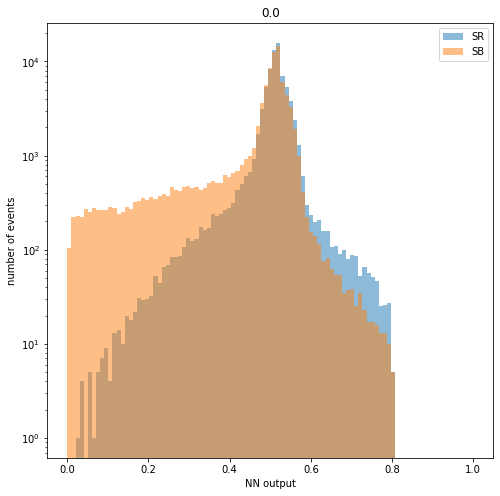

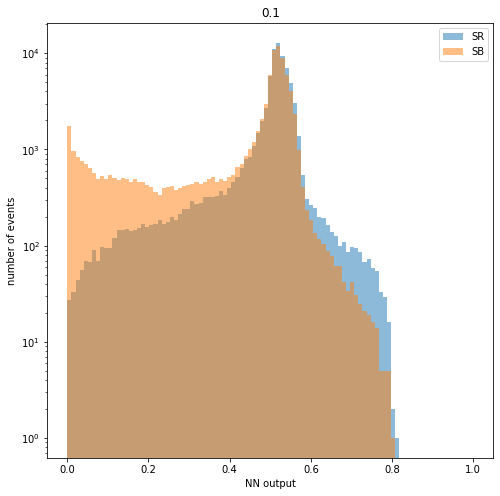

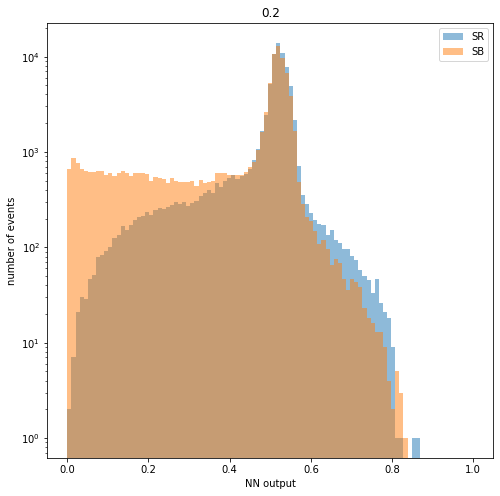

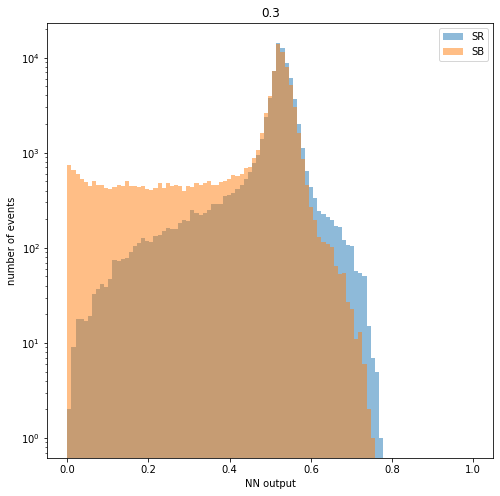

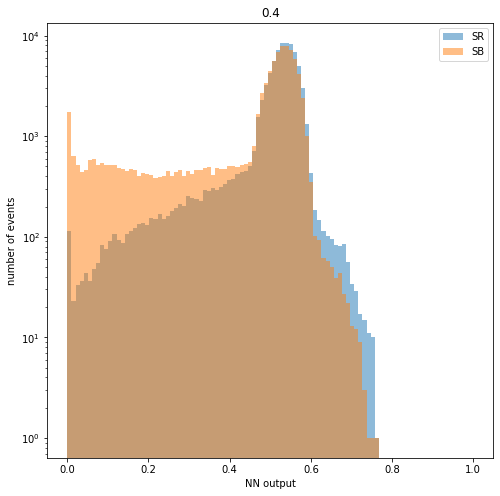

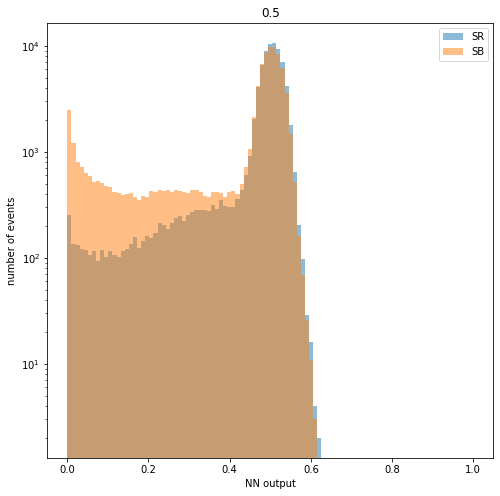

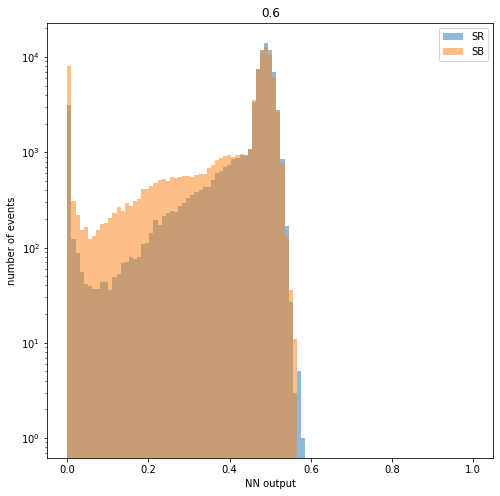

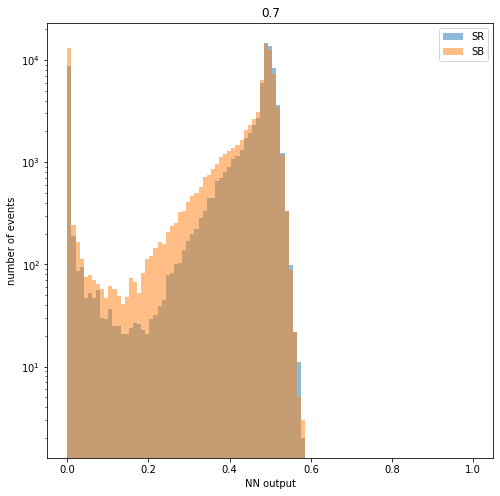

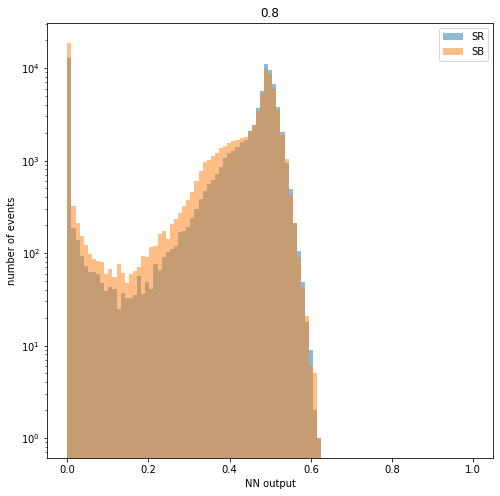

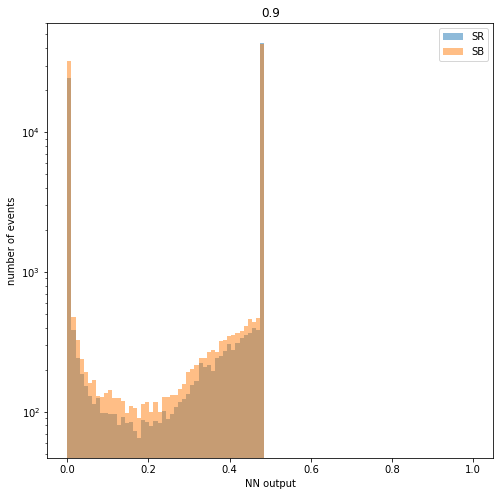

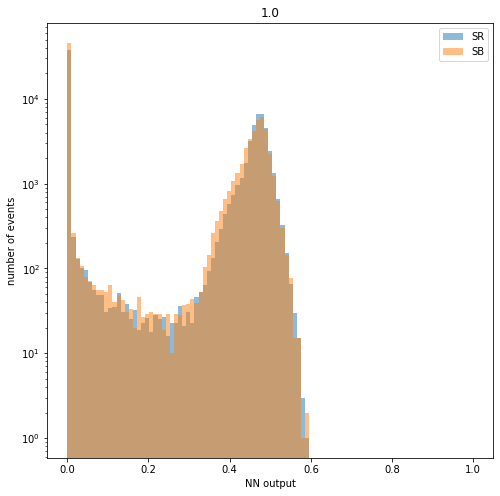

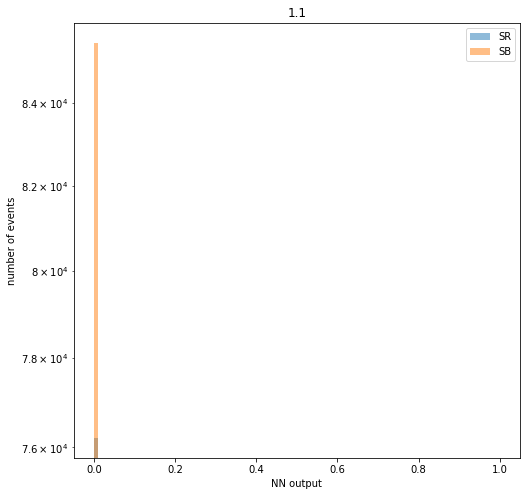

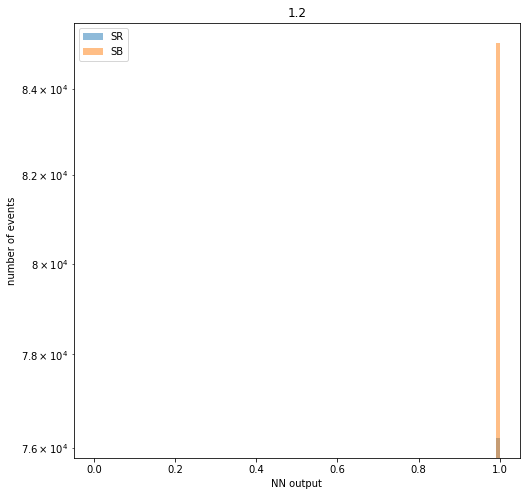

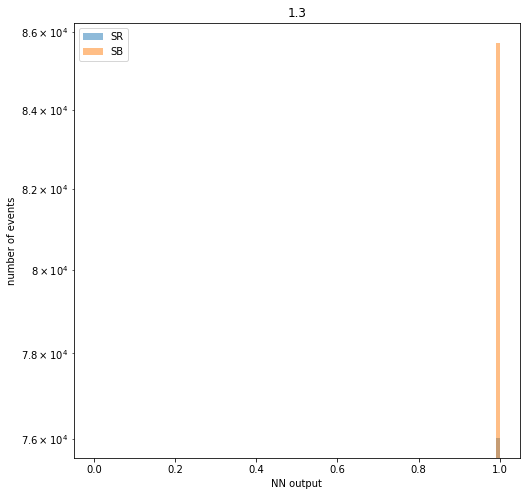

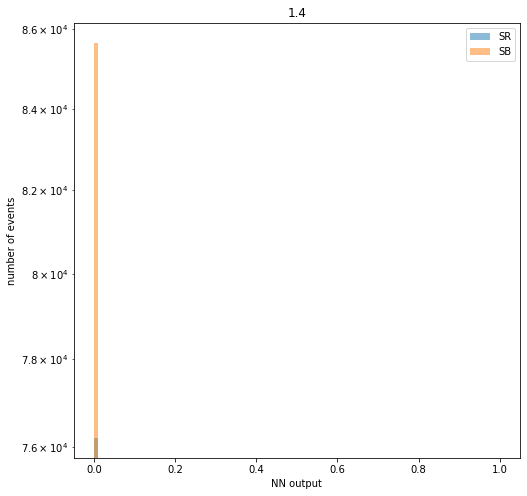

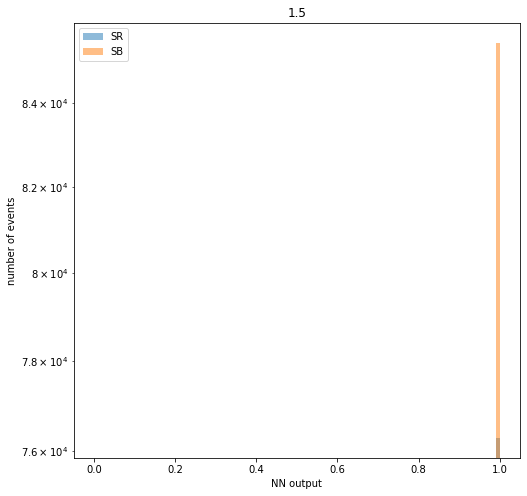

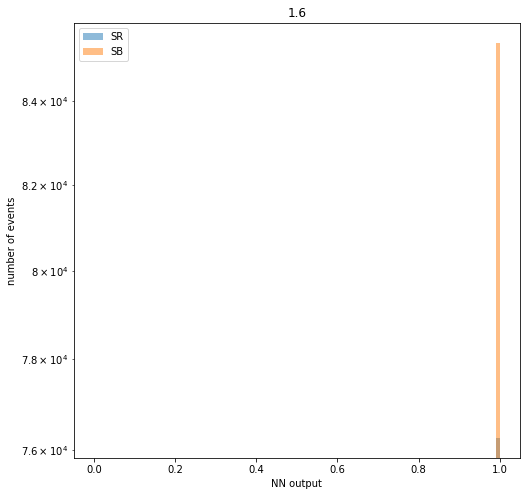

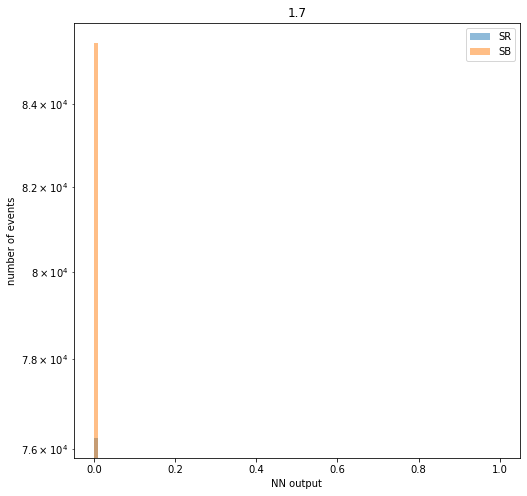

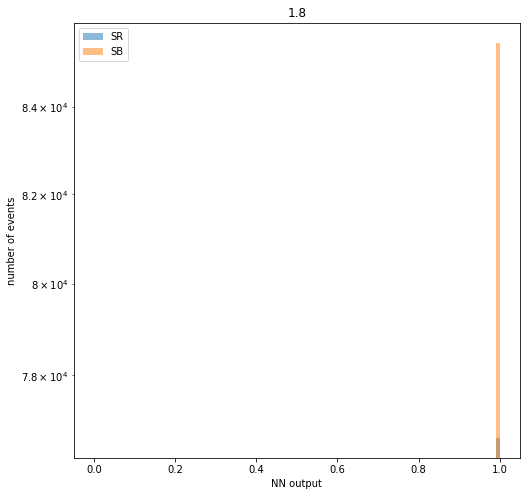

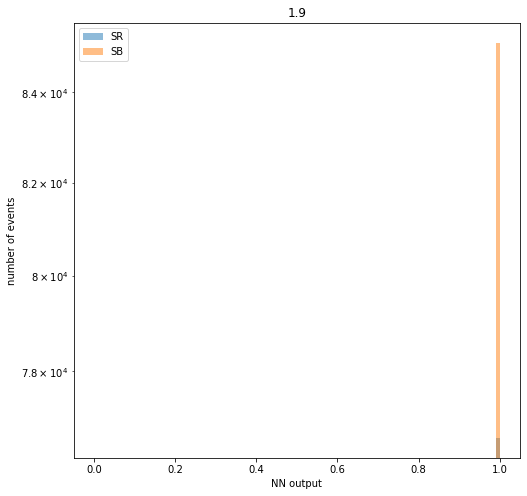

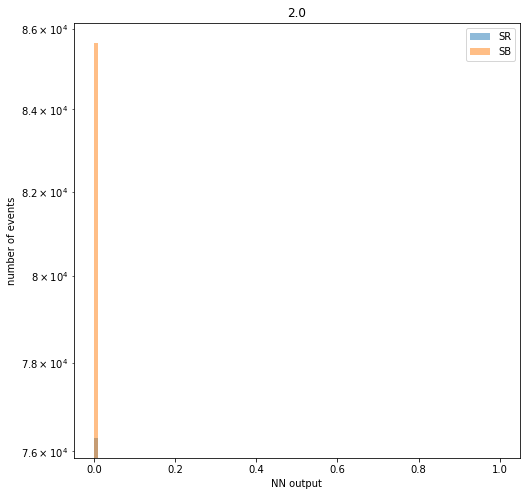

In [13]:
myaucs = []
histories = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    
    print(mylambda)

    X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC))])
    W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))
    histories+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)
    
    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()


Text(0.5, 0, '$\\lambda$')

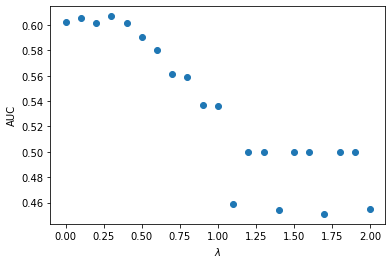

In [14]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")

In [15]:
x_SR_signal = x_signal[(mjj_signal > SR_low)*(mjj_signal < SR_high)]
x_SR_data = x_data[(mjj_pythia > SR_low)*(mjj_pythia < SR_high)]
x_SR_MC = x_MC[(mjj_herwig > SR_low)*(mjj_herwig < SR_high)]

x_SB_signal = x_signal[(mjj_signal < SR_low)*(mjj_signal > SB_low)+(mjj_signal < SB_high)*(mjj_signal > SR_high)]
x_SB_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)+(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]
x_SB_MC = x_MC[(mjj_herwig < SR_low)*(mjj_herwig > SB_low)+(mjj_herwig < SB_high)*(mjj_herwig > SR_high)]

x_SB_low_data = x_data[(mjj_pythia < SR_low)*(mjj_pythia > SB_low)]
x_SB_high_data = x_data[(mjj_pythia < SB_high)*(mjj_pythia > SR_high)]

In [16]:
print(len(x_SB_low_data))
print(len(x_SB_high_data))
print(len(x_SR_data))

127601
43046
152668


1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 1/20
246981/246981 [==============================] - 11s 44us/step - loss: 0.6439 - acc: 0.5005 - val_loss: 0.6334 - val_acc: 0.4951
Epoch 2/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6281 - acc: 0.5305 - val_loss: 0.6241 - val_acc: 0.5274
Epoch 3/20
246981/246981 [==============================] - 10s 41us/step - loss: 0.6267 - acc: 0.5335 - val_loss: 0.6245 - val_acc: 0.5250
Epoch 4/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6252 - acc: 0.5338 - val_loss: 0.6274 - val_acc: 0.5479
Epoch 5/20
246981/246981 [==============================] - 10s 41us/step - loss: 0.6251 - acc: 0.5335 - val_loss: 0.6297 - val_acc: 0.5124
Epoch 6/20
246981/246981 [==============================] - 10s 40us/step - loss: 0.6249 - acc: 0.5329 - val_loss: 0.6236 - val_acc: 0.5233
Epoch 7/20
246981/246981 [=====================

246981/246981 [==============================] - 10s 39us/step - loss: -0.3089 - acc: 0.4932 - val_loss: -0.3496 - val_acc: 0.4787
Epoch 12/20
246981/246981 [==============================] - 10s 41us/step - loss: -0.2945 - acc: 0.4942 - val_loss: -0.3576 - val_acc: 0.4997
Epoch 13/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3004 - acc: 0.4938 - val_loss: -0.3290 - val_acc: 0.5023
Epoch 14/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.2939 - acc: 0.4958 - val_loss: -0.3456 - val_acc: 0.5036
Epoch 15/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3038 - acc: 0.4941 - val_loss: -0.3337 - val_acc: 0.5219
Epoch 16/20
246981/246981 [==============================] - 10s 40us/step - loss: -0.3036 - acc: 0.4944 - val_loss: -0.2234 - val_acc: 0.5414
Epoch 17/20
246981/246981 [==============================] - 10s 42us/step - loss: -0.3006 - acc: 0.4946 - val_loss: -0.2650 - val_acc: 0.4677
Epoch 18/20

246981/246981 [==============================] - 11s 43us/step - loss: -3.0234 - acc: 0.4890 - val_loss: -3.0269 - val_acc: 0.4950
1.0 0.578367982774179
1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 1/20
246981/246981 [==============================] - 13s 51us/step - loss: -2.2884 - acc: 0.4946 - val_loss: -3.6154 - val_acc: 0.4977
Epoch 2/20
246981/246981 [==============================] - 11s 43us/step - loss: -3.5850 - acc: 0.4884 - val_loss: -3.5961 - val_acc: 0.5103
Epoch 3/20
246981/246981 [==============================] - 11s 43us/step - loss: -3.6251 - acc: 0.4890 - val_loss: -3.7146 - val_acc: 0.4899
Epoch 4/20
246981/246981 [==============================] - 10s 42us/step - loss: -3.6326 - acc: 0.4887 - val_loss: -3.6812 - val_acc: 0.4811
Epoch 5/20
246981/246981 [==============================] - 11s 44us/step - loss: -3.6521 - acc: 0.4899 - val_loss: -3.7213 - val_acc: 0.4912
Epoch 6/20
246981/246981

Epoch 15/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0143 - acc: 0.4884 - val_loss: -5.1695 - val_acc: 0.4958
Epoch 16/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0243 - acc: 0.4872 - val_loss: -5.0165 - val_acc: 0.5101
Epoch 17/20
246981/246981 [==============================] - 11s 44us/step - loss: -5.0073 - acc: 0.4819 - val_loss: -5.1764 - val_acc: 0.4763
Epoch 18/20
246981/246981 [==============================] - 11s 44us/step - loss: -5.0404 - acc: 0.4880 - val_loss: -4.9867 - val_acc: 0.4614
Epoch 19/20
246981/246981 [==============================] - 11s 43us/step - loss: -4.9986 - acc: 0.4844 - val_loss: -5.2166 - val_acc: 0.4782
Epoch 20/20
246981/246981 [==============================] - 11s 43us/step - loss: -5.0143 - acc: 0.4845 - val_loss: -5.1191 - val_acc: 0.5024
1.3 0.5806506278873107
1.0 0.8946421560296988 1.1964483036966795 3.5466245411884962
Train on 246981 samples, validate on 246981 samples
Epoch 

246981/246981 [==============================] - 11s 43us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 4/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 5/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 6/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 7/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 8/20
246981/246981 [==============================] - 11s 45us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 9/20
246981/246981 [==============================] - 11s 44us/step - loss: -4.4142 - acc: 0.5679 - val_loss: -4.4549 - val_acc: 0.5669
Epoch 10/20
24698

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


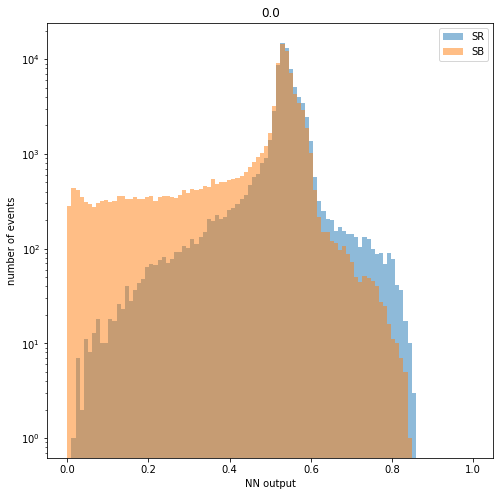

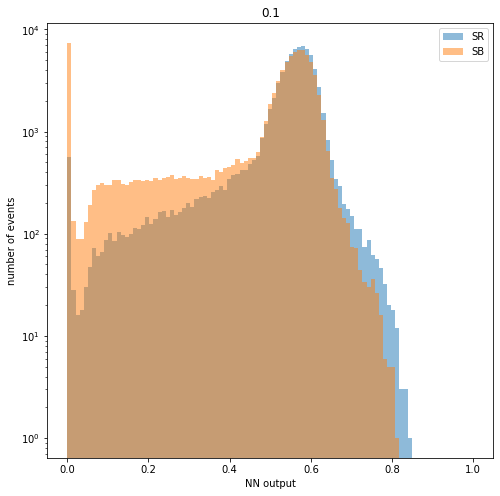

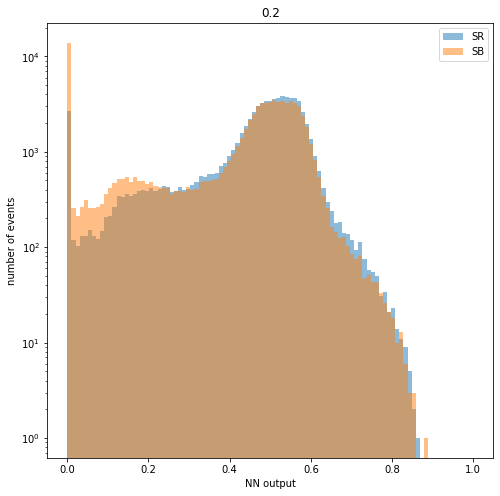

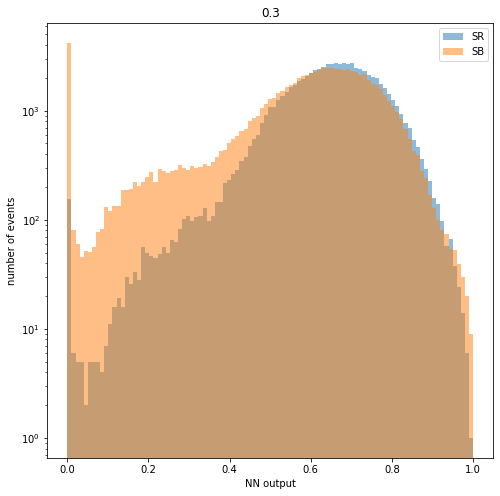

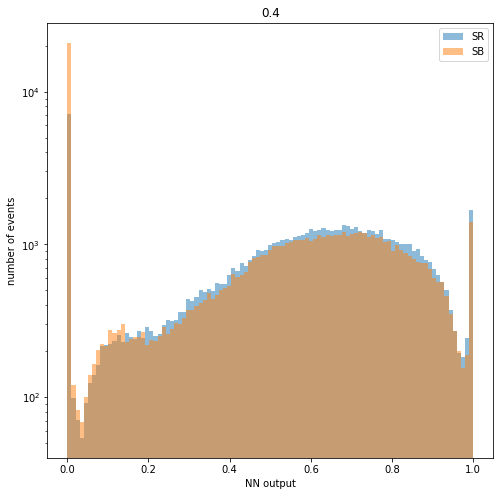

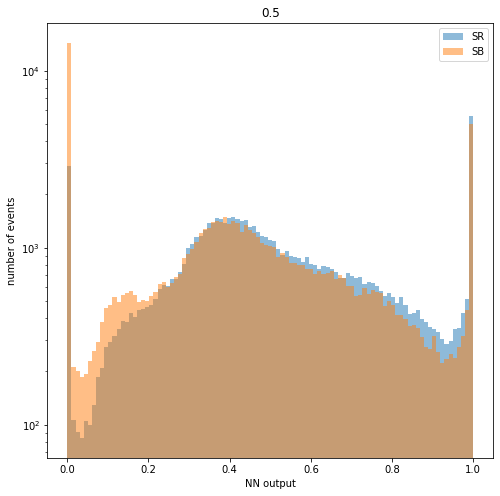

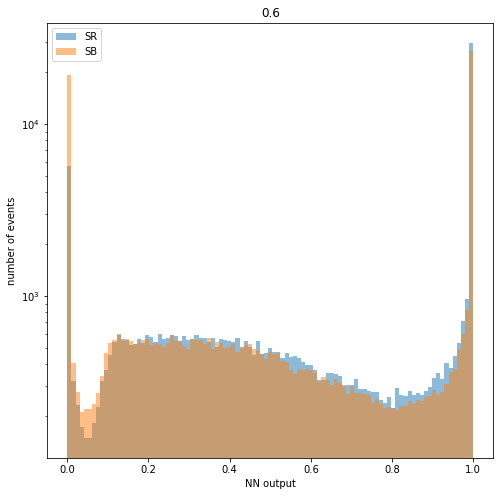

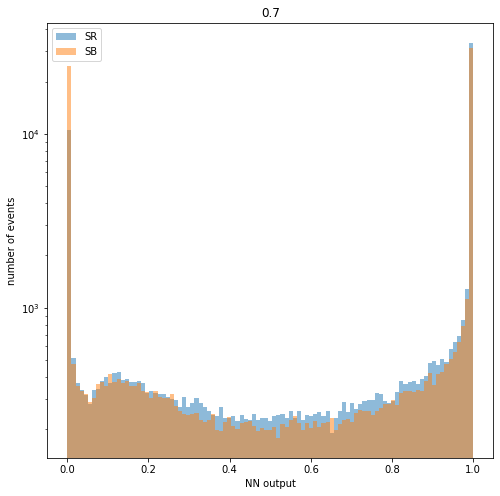

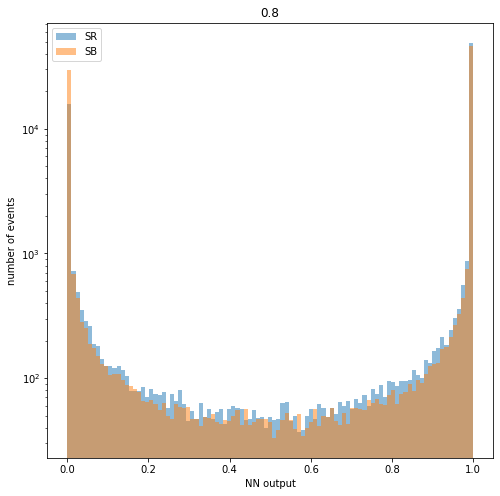

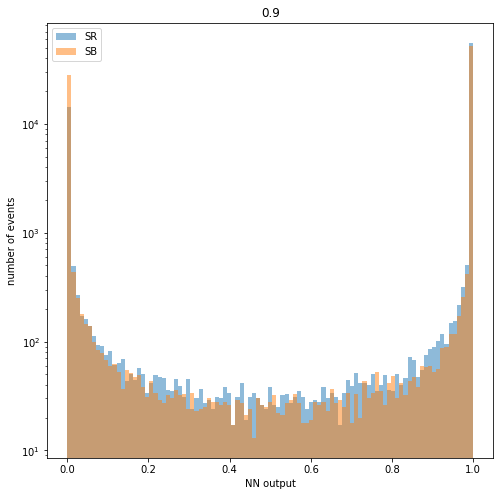

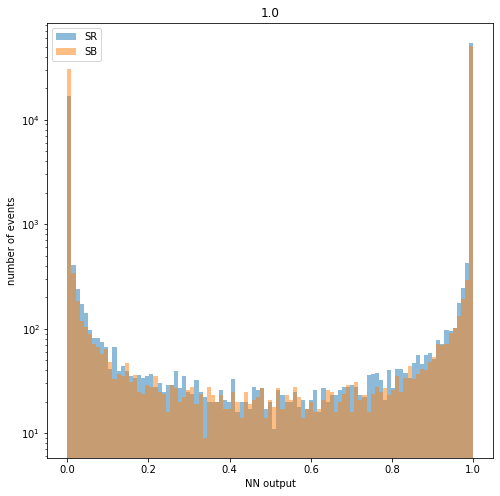

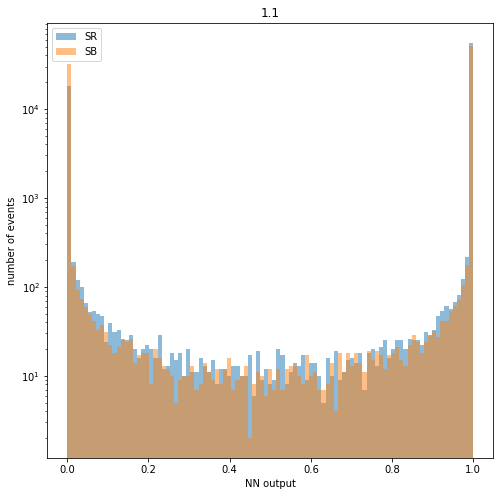

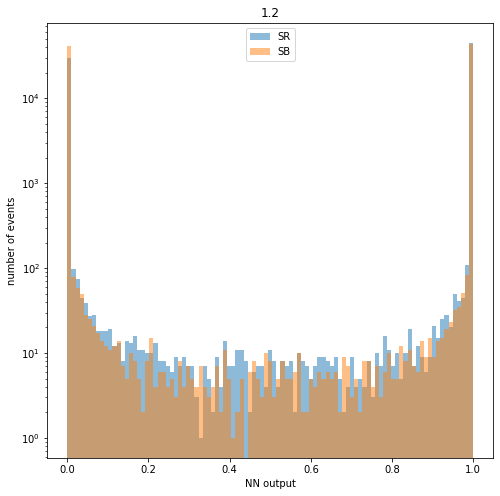

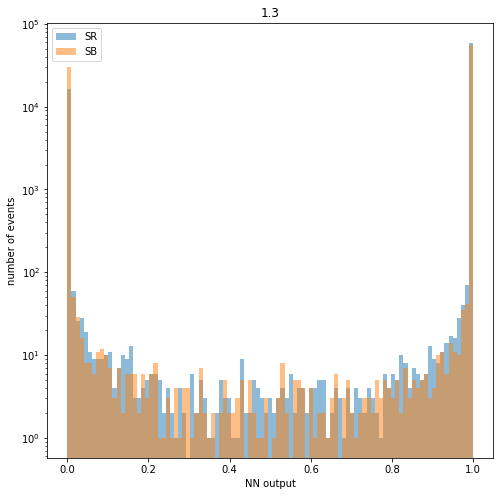

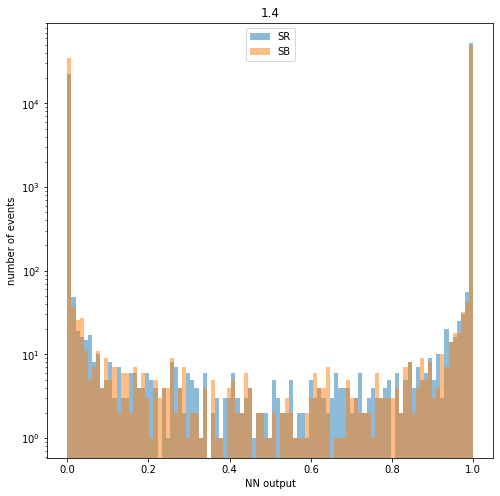

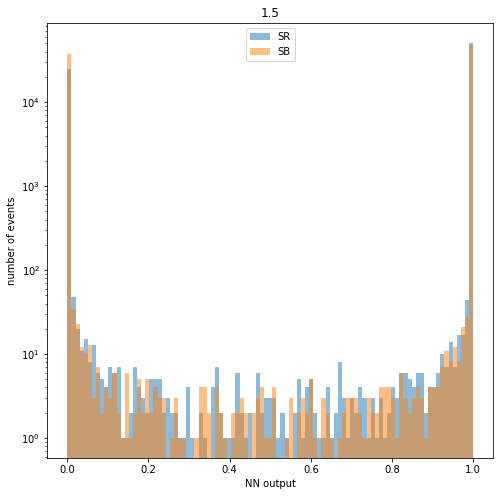

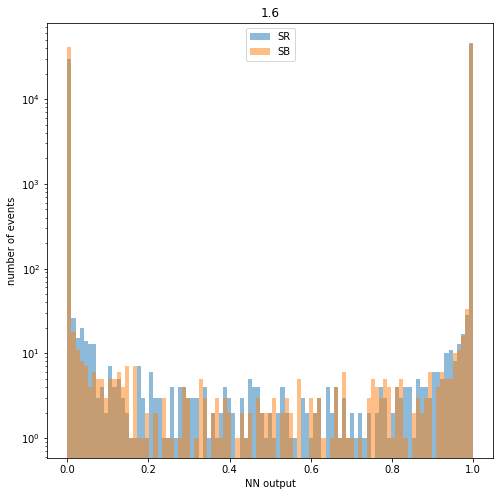

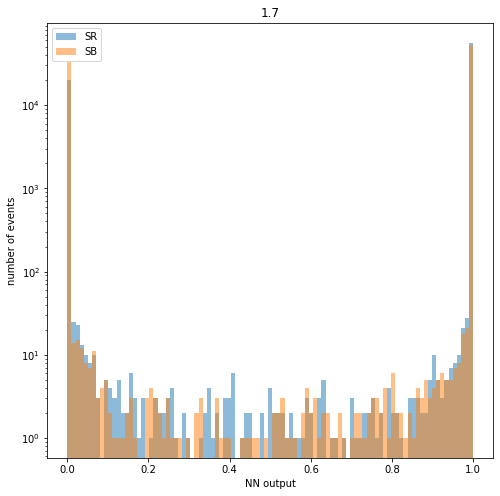

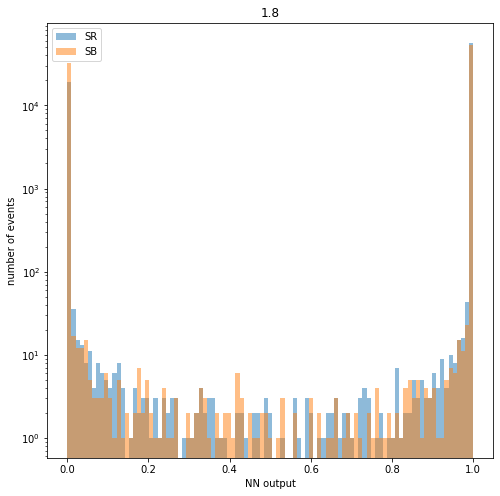

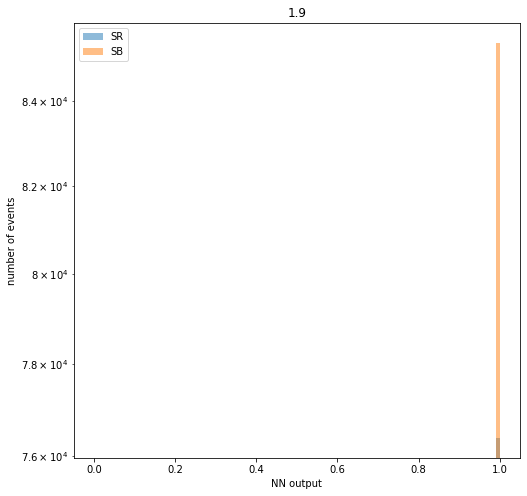

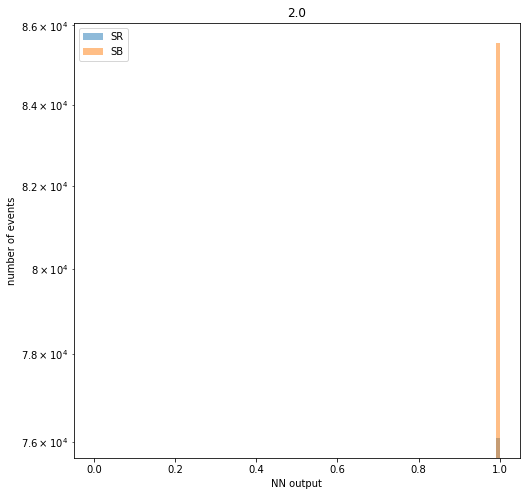

In [17]:
myaucs2 = []
histories2 = []
nepochs = 20
for mylambda in [0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.]:
    X = np.concatenate([x_SR_data,x_SB_data,x_SB_low_data,x_SB_high_data])
    Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SB_low_data)),np.zeros(len(x_SB_high_data))])
    w_SR = 1.
    w_SB = len(x_SR_data)/len(x_SB_data)
    w_SB_low = len(x_SR_data)/len(x_SB_low_data)
    w_SB_high = len(x_SR_data)/len(x_SB_high_data)
    print(w_SR,w_SB,w_SB_low,w_SB_high)
    W = np.concatenate([w_SR*np.ones(len(x_SR_data)),w_SB*np.ones(len(x_SB_data)),-mylambda*w_SB_low*np.ones(len(x_SB_low_data)),-mylambda*w_SB_high*np.ones(len(x_SB_high_data))])
    X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

    model = Sequential()
    model.add(Dense(64, input_dim=4, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

    histories2+=[history]
    
    preds_SR = model.predict(X_test[(Y_test==1)*(W_test>0)],batch_size=200)
    preds_SB = model.predict(X_test[(Y_test==0)*(W_test>0)],batch_size=200)

    print(mylambda,roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB])))
    myaucs2+=[roc_auc_score(np.concatenate([np.ones(len(preds_SR)),np.zeros(len(preds_SB))]), np.concatenate([preds_SR,preds_SB]))]
    
    fig = plt.figure(figsize=(8, 8))
    _,_,_=plt.hist(preds_SR,label="SR",bins=np.linspace(0,1,100),alpha=0.5)
    _,_,_=plt.hist(preds_SB,label="SB",bins=np.linspace(0,1,100),alpha=0.5)
    plt.yscale("log")
    plt.xlabel("NN output")
    plt.ylabel("number of events")
    plt.title(str(mylambda))
    plt.legend()

Text(0.5, 0, '$\\lambda$')

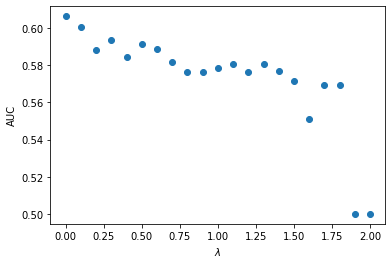

In [20]:
plt.plot([0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.],myaucs2,marker="o",linestyle="none")
plt.ylabel("AUC")
plt.xlabel(r"$\lambda$")
#plt.xlim([0,1])

In [ ]:
#Now, try with signal injected to make sure that is preserved.

In [26]:
mylambda = 0.
X = np.concatenate([x_SR_data,x_SB_data,x_SR_MC,x_SB_MC,x_SR_signal,x_SB_signal])
Y = np.concatenate([np.ones(len(x_SR_data)),np.zeros(len(x_SB_data)),np.ones(len(x_SR_MC)),np.zeros(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.zeros(len(x_SB_signal))])
W = np.concatenate([np.ones(len(x_SR_data)),np.ones(len(x_SB_data)),-mylambda*np.ones(len(x_SR_MC)),-mylambda*np.ones(len(x_SB_MC)),np.ones(len(x_SR_signal)),np.ones(len(x_SB_signal))])
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(X, Y, W, test_size=0.5)

model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu')) 
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,Y_train, epochs=nepochs, sample_weight = W_train, batch_size=200,validation_data=(X_test,Y_test,W_test))

preds_SR = model.predict(np.concatenate([x_SR_data,x_SB_signal]),batch_size=200)

Train on 370845 samples, validate on 370845 samples
Epoch 1/20
370845/370845 [==============================] - 19s 52us/step - loss: 0.6179 - acc: 0.5684 - val_loss: 0.6066 - val_acc: 0.5791
Epoch 2/20
370845/370845 [==============================] - 17s 45us/step - loss: 0.6000 - acc: 0.5931 - val_loss: 0.5956 - val_acc: 0.5966
Epoch 3/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5960 - acc: 0.5974 - val_loss: 0.5931 - val_acc: 0.5927
Epoch 4/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5951 - acc: 0.5991 - val_loss: 0.5917 - val_acc: 0.6048
Epoch 5/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5945 - acc: 0.5987 - val_loss: 0.5950 - val_acc: 0.6011
Epoch 6/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5943 - acc: 0.5996 - val_loss: 0.5912 - val_acc: 0.6014
Epoch 7/20
370845/370845 [==============================] - 16s 44us/step - loss: 0.5935 - acc: 0.6002 - val

ValueError: continuous format is not supported

In [35]:
fpr, tpr, thresholds_norotate = roc_curve(np.concatenate([np.zeros(len(x_SR_data)),np.ones(len(x_SB_signal))]),preds_SR[:,0])

/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/myenv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


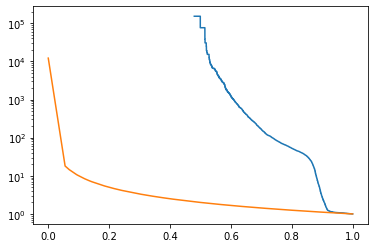

In [40]:
plt.plot(tpr,1./fpr)
plt.plot(tpr,1./tpr)
plt.yscale("log")